In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor

import os
from data import processing_data
from settings import BASE_DIR

# Loading our dataset

data_path = os.path.join(BASE_DIR, "dataset", "train.csv")
df = pd.read_csv(data_path)
df.head()

,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,"Supernatural Horror, Vampire Horror, Horror, T...",5.6,33000,47.000000,2024.0,851156.0,26000000.0,United States,17.073607,10.404293,13.654352,1
1,"Drama, Music, Romance",5.6,23000,55.000000,2017.0,1813453.0,26000000.0,United States,17.073607,10.043293,14.410744,1
2,"Computer Animation, Adventure, Animation, Come...",6.0,18000,53.000000,2023.0,209646030.0,95000000.0,"United States, United Kingdom",18.369387,9.798183,19.160931,8
3,"Body Horror, Folk Horror, Monster Horror, Supe...",4.5,12000,45.000000,2024.0,2014050.0,20000000.0,"United States, United Kingdom, Germany, Bulgaria",16.811243,9.392745,14.515659,1
4,"Steamy Romance, Drama, Romance",6.0,27000,64.812903,2010.0,844281.0,26000000.0,Spain,17.073607,10.203629,13.646242,1


| Siêu tham số           | Ý nghĩa                                                                 | Giá trị phổ biến / Mặc định       | Ảnh hưởng đến mô hình                                                        |
|------------------------|------------------------------------------------------------------------|-----------------------------------|--------------------------------------------------------------------------------|
| `n_estimators`         | Số lượng cây trong rừng                                                | `[50, 100, 200, 300]` (mặc định: 100) | Tăng số lượng cây giúp mô hình ổn định hơn nhưng huấn luyện lâu hơn         |
| `max_depth`            | Độ sâu tối đa của cây                                                  | `[None, 5, 10, 15]`               | Giới hạn độ sâu tránh overfitting; `None` cho phép cây phát triển tối đa    |
| `min_samples_split`    | Số mẫu tối thiểu để chia một node                                      | `[2, 5, 10]`                      | Giá trị lớn làm cây bớt phức tạp, tránh chia nhỏ quá mức                     |
| `min_samples_leaf`     | Số mẫu tối thiểu tại một node lá                                       | `[1, 3, 5]`                       | Tăng giá trị giúp cây tổng quát hơn, giảm overfitting                        |
| `max_features`         | Số lượng đặc trưng được xét tại mỗi lần chia node                      | `['sqrt', 'log2', None]`         | Tăng tính ngẫu nhiên, giúp đa dạng hóa cây và giảm overfitting               |
| `bootstrap`            | Có sử dụng lấy mẫu có hoàn lại không                                   | `[True, False]`                  | `True` giúp đa dạng hóa cây (giảm overfitting), `False` dùng toàn bộ dữ liệu |
| `criterion`            | Hàm mất mát để đánh giá chất lượng node                               | `['squared_error', 'absolute_error']` | `squared_error` nhạy với outlier; `absolute_error` bền vững hơn với outlier  |
| `max_leaf_nodes`       | Số lượng node lá tối đa (giới hạn cấu trúc cây)                        | `None` hoặc số nguyên dương       | Giới hạn này giúp kiểm soát độ phức tạp mô hình                              |
| `n_jobs`               | Số luồng CPU sử dụng để train song song                                | `-1` (tất cả CPU)                | Tăng tốc độ huấn luyện mô hình                                               |
| `random_state`         | Hạt giống ngẫu nhiên cho reproducibility                               | `42`, hoặc số bất kỳ             | Giúp kết quả có thể lặp lại khi huấn luyện nhiều lần                         |



 Fold 1
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Training Metrics
R2 score: 0.8050
MAE: 39,853,865.8034
MAPE: 2.69%
Test Metrics
R2 score: 0.5952
MAE: 63,513,181.9875
MAPE: 18.97%


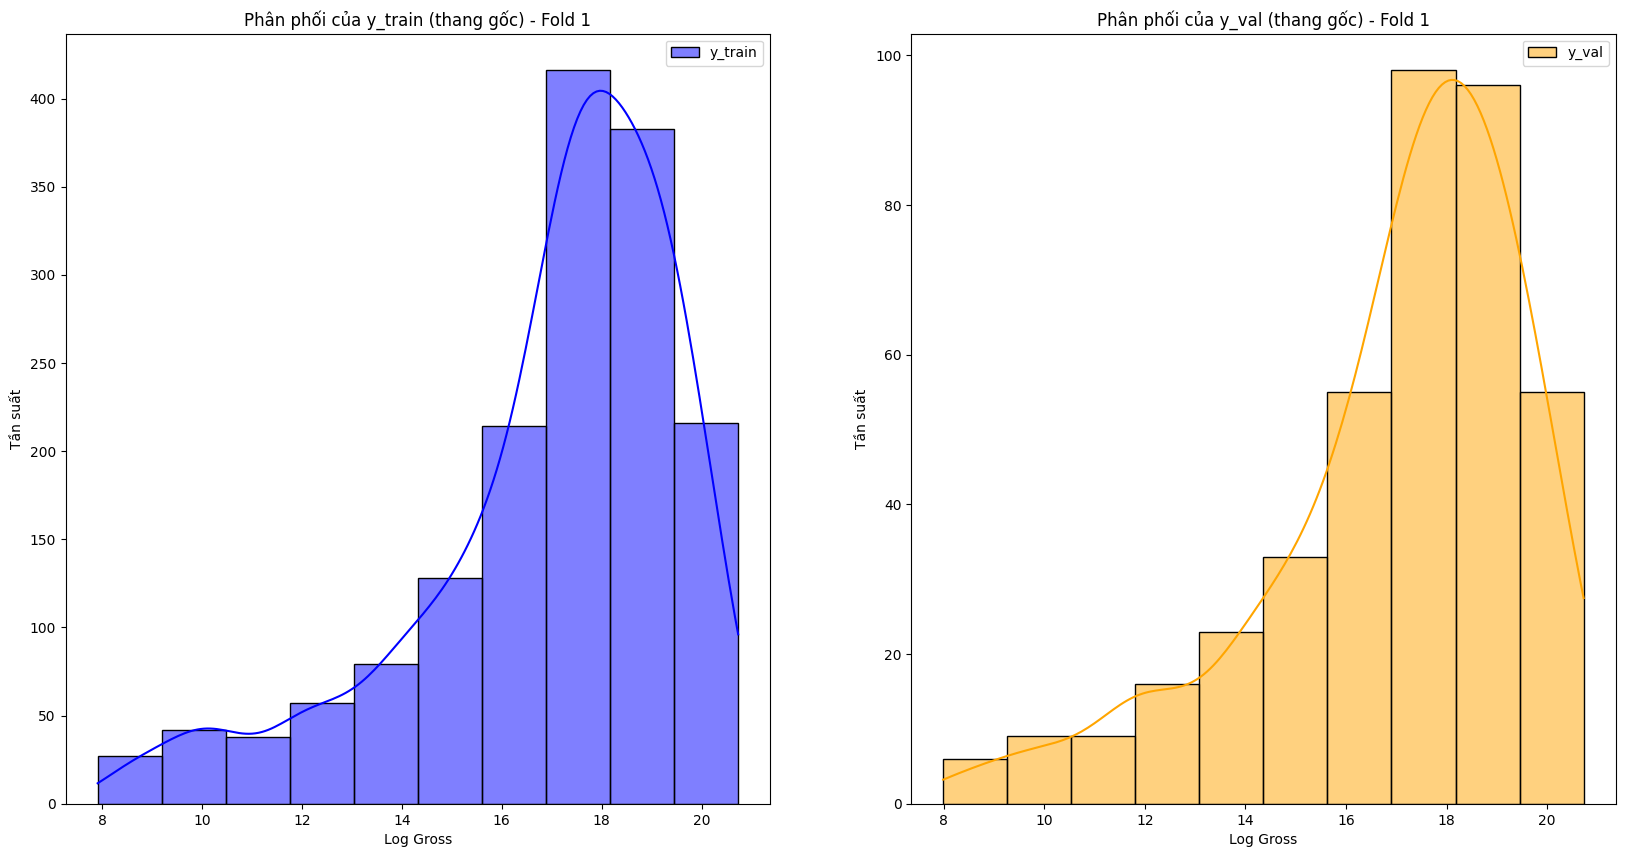

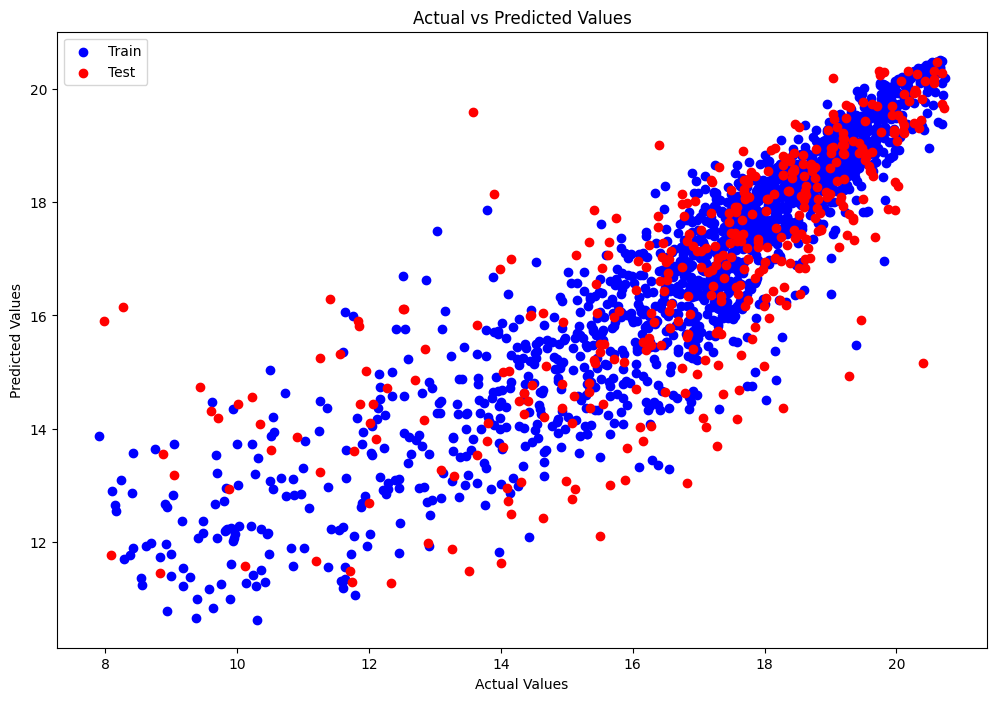

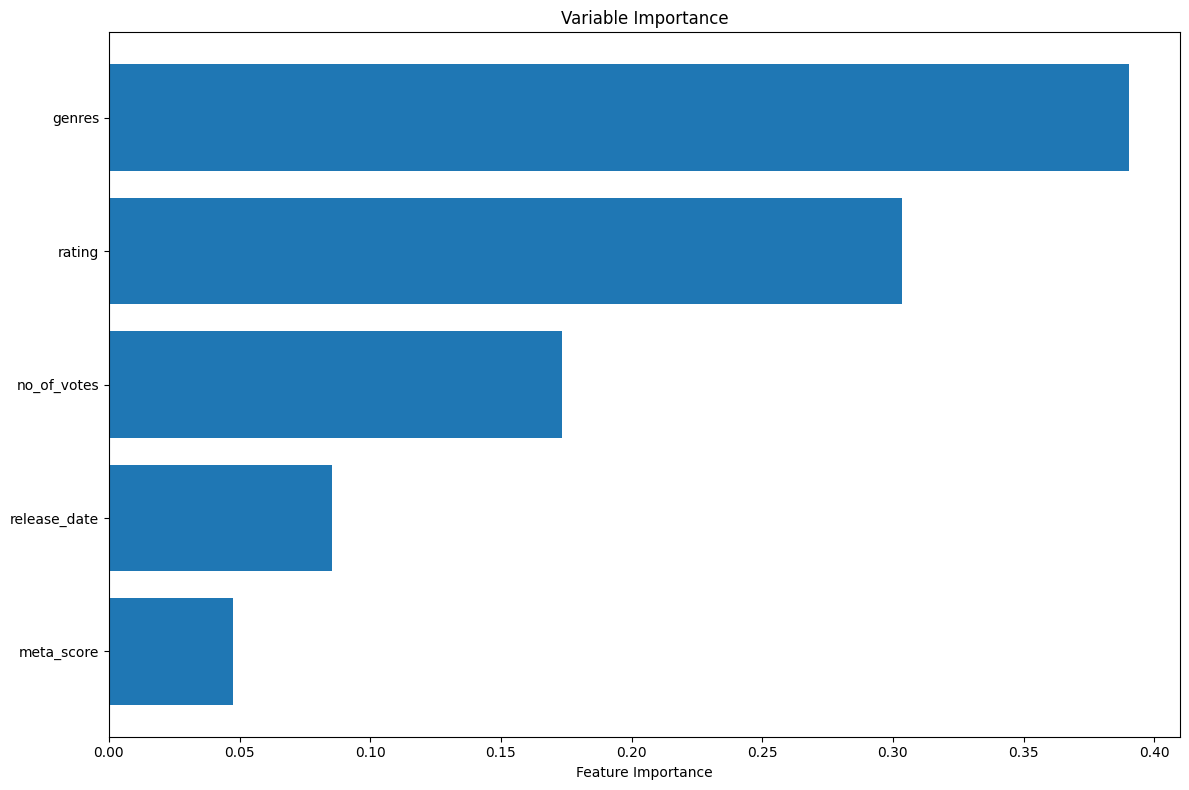


 Fold 2
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Training Metrics
R2 score: 0.7757
MAE: 44,696,861.3719
MAPE: 4.28%
Test Metrics
R2 score: 0.5900
MAE: 64,444,567.5973
MAPE: 14.90%


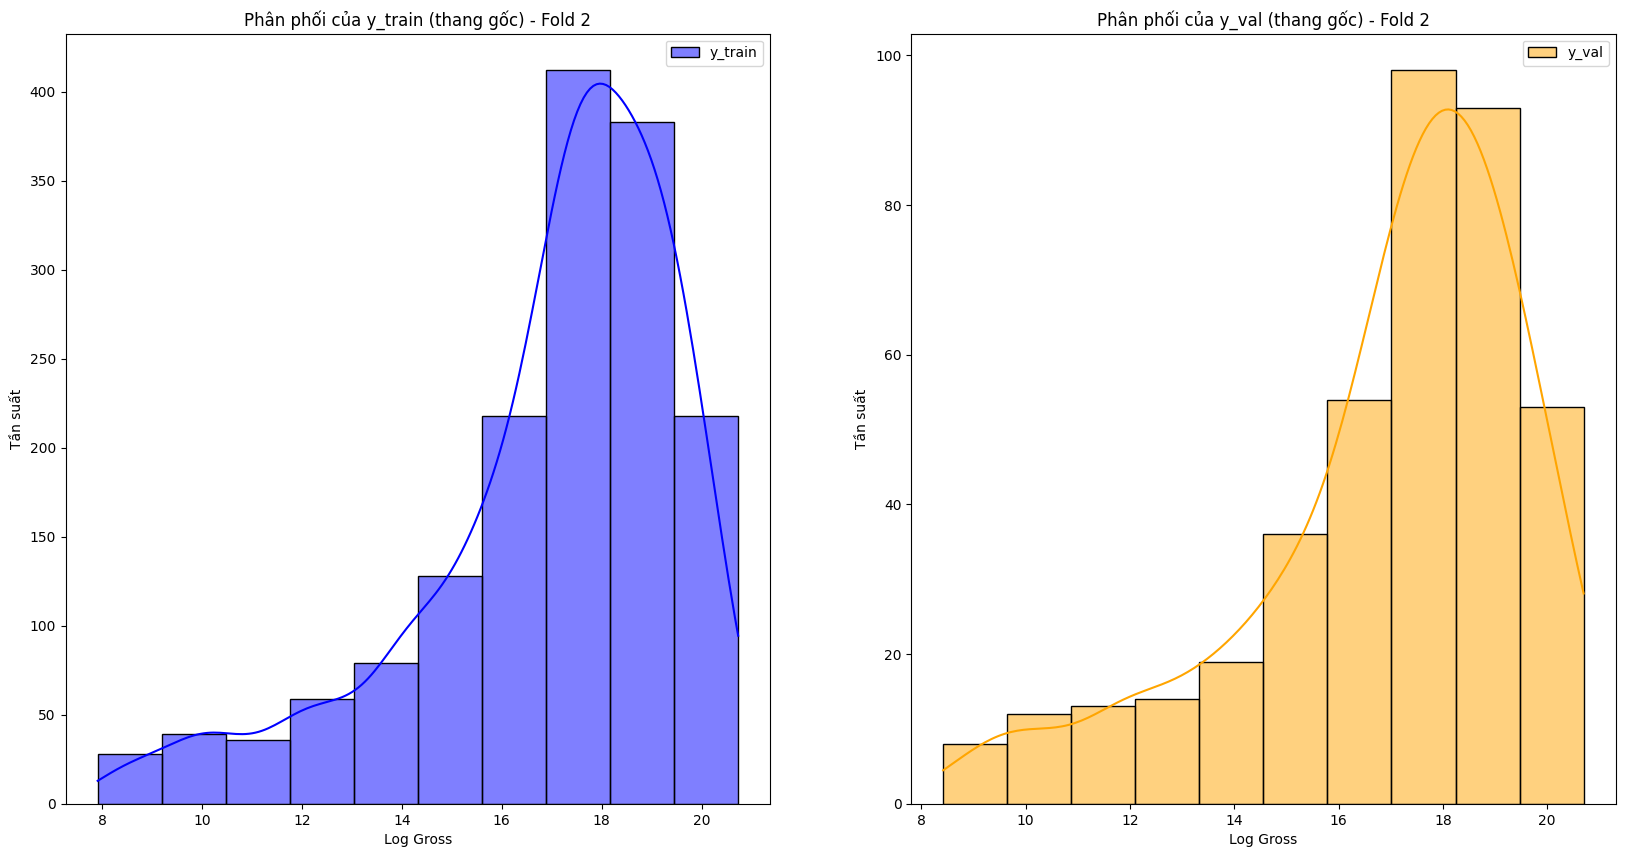

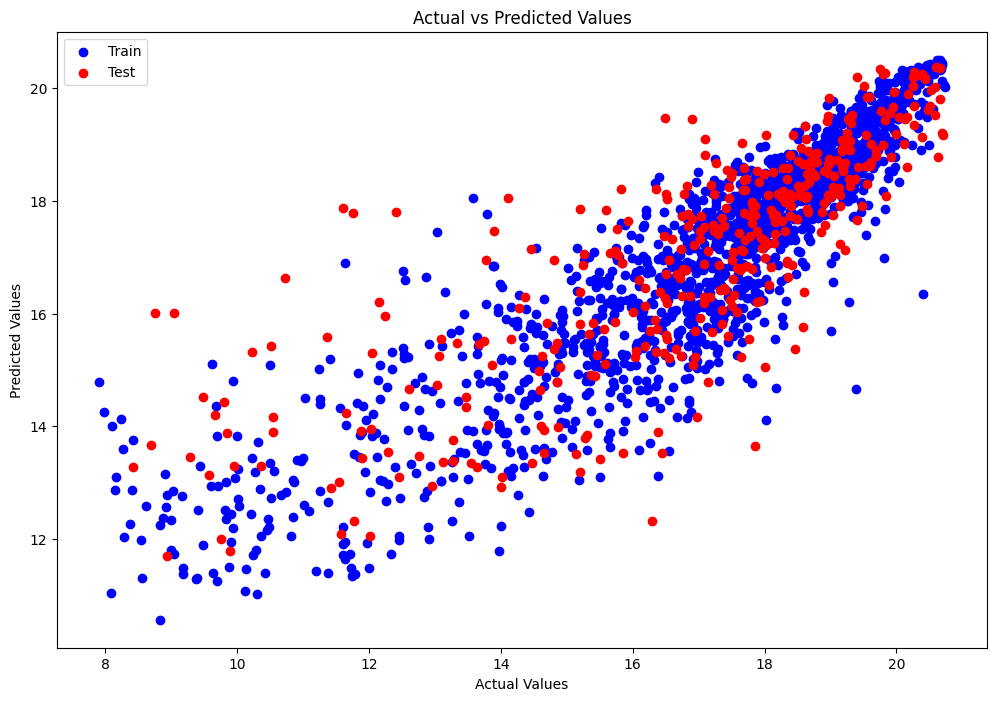

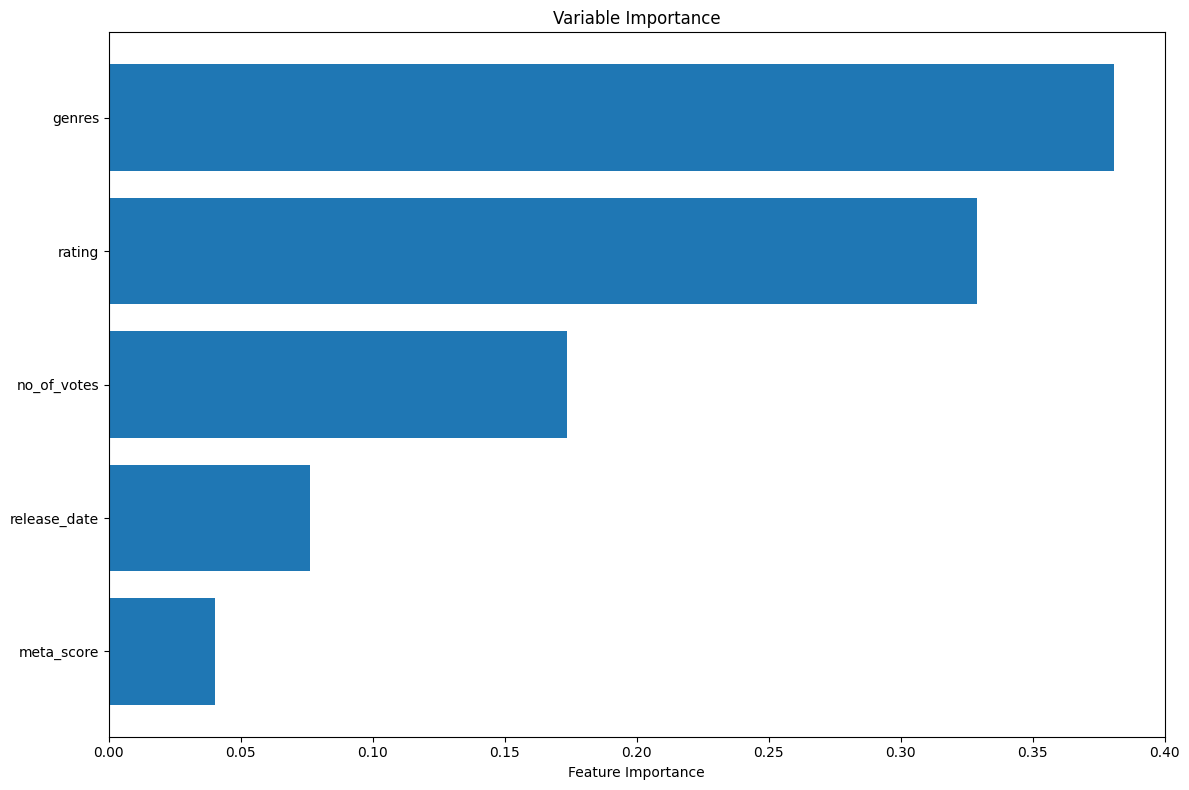


 Fold 3
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Training Metrics
R2 score: 0.7613
MAE: 45,773,783.3372
MAPE: 3.52%
Test Metrics
R2 score: 0.6802
MAE: 57,604,412.0378
MAPE: 30.82%


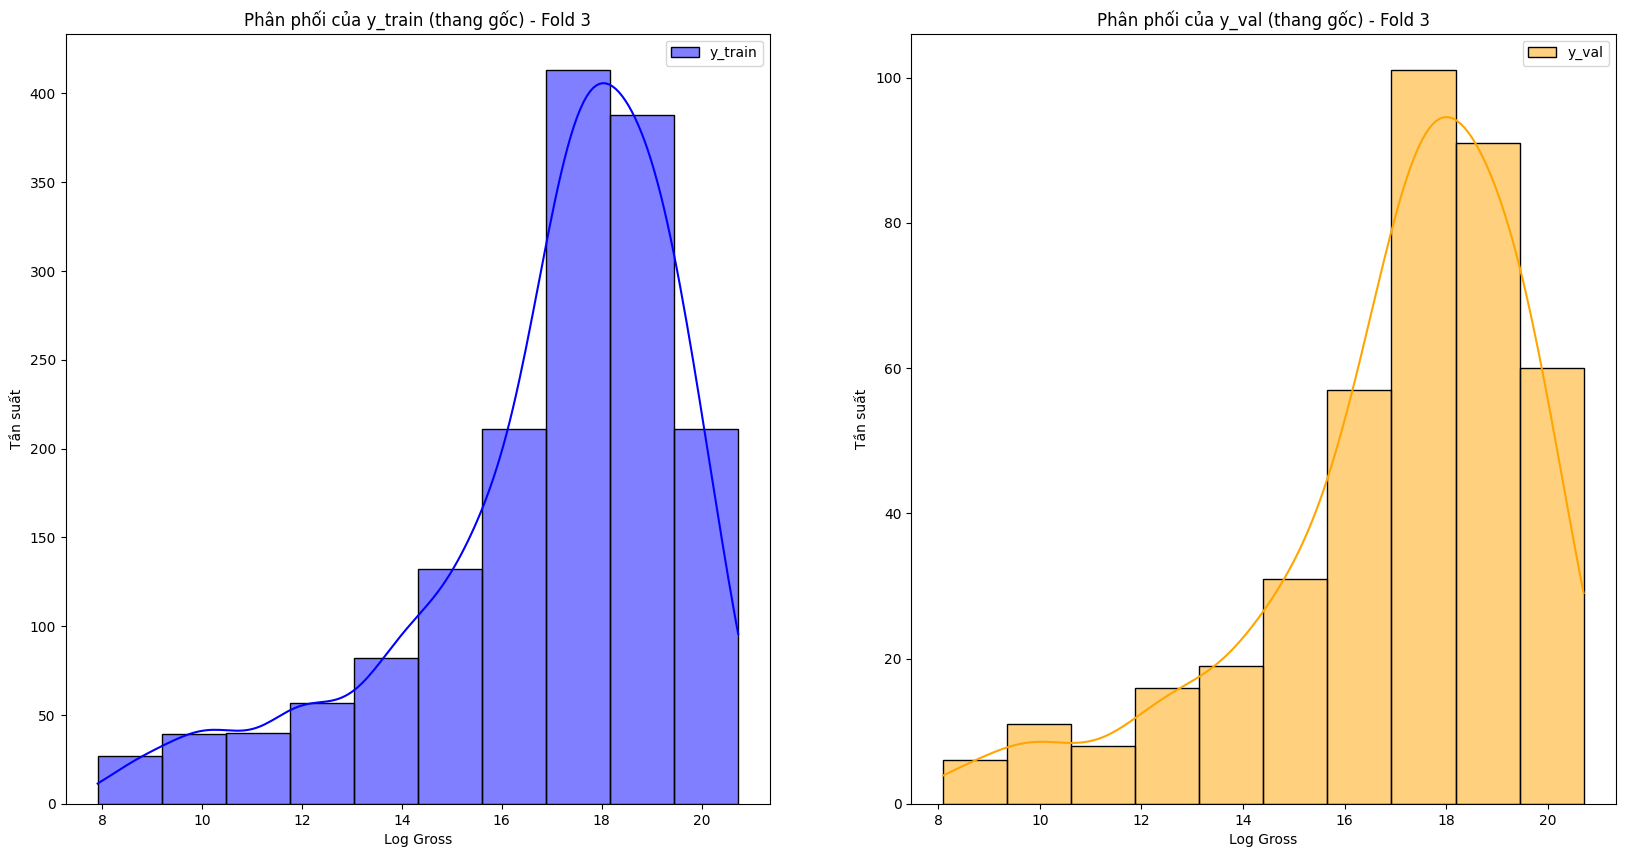

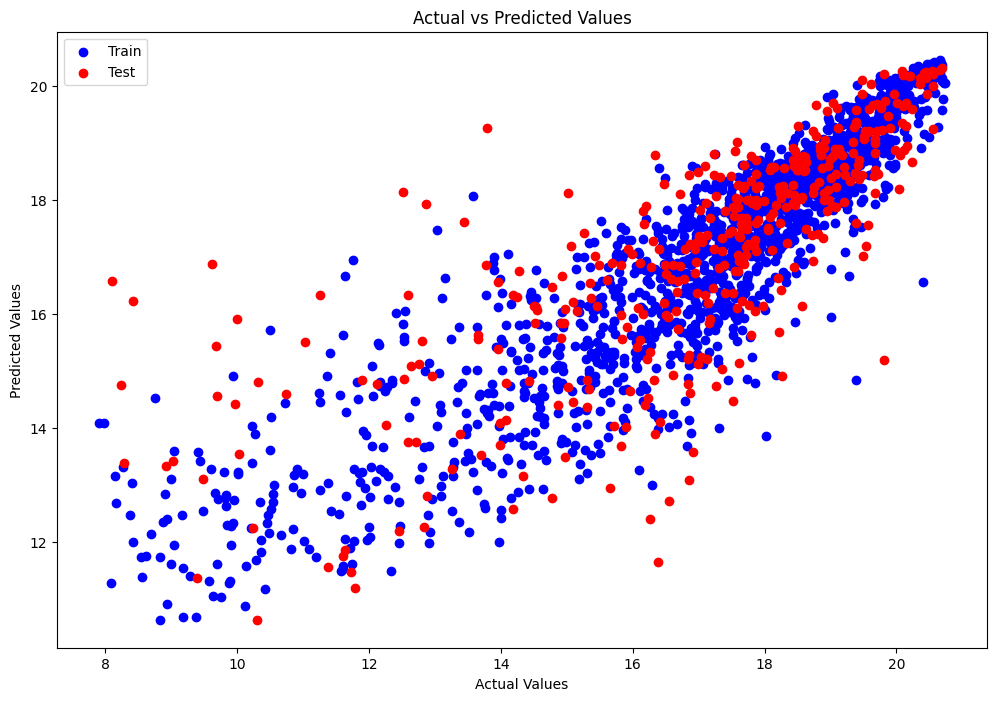

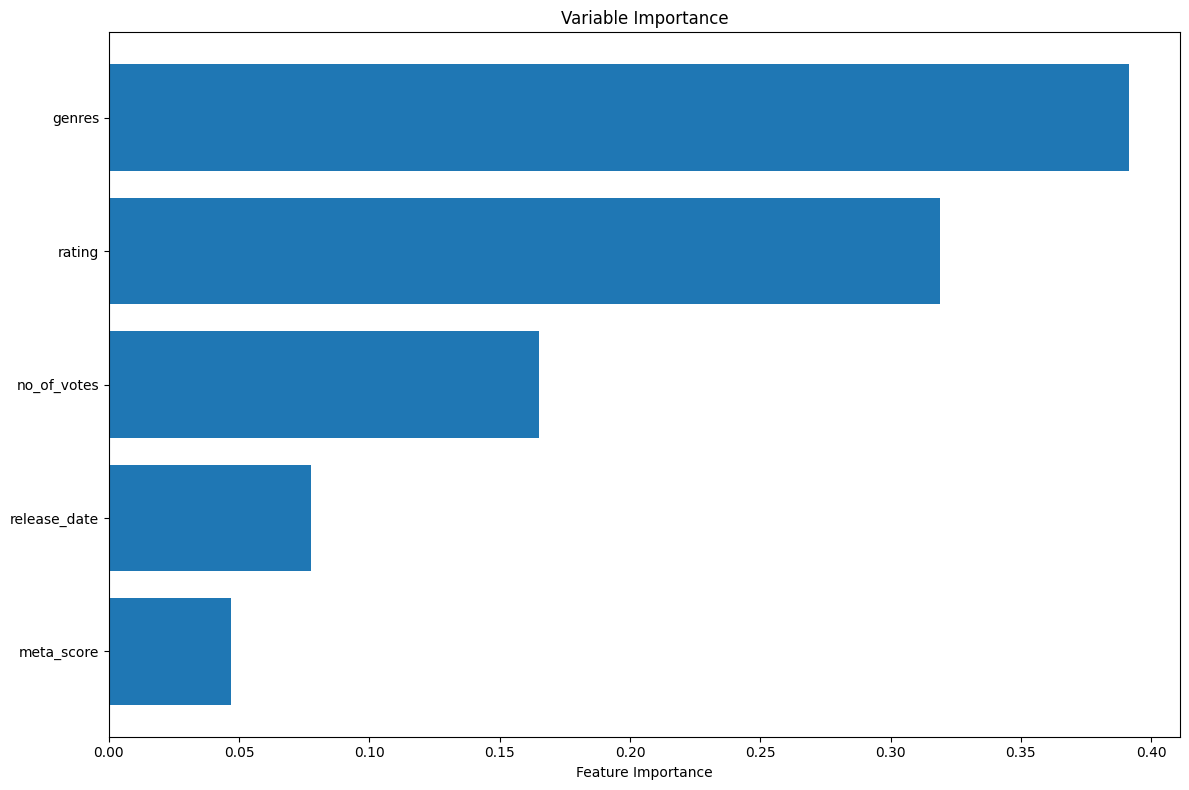


 Fold 4
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Training Metrics
R2 score: 0.7652
MAE: 45,699,601.5457
MAPE: 3.66%
Test Metrics
R2 score: 0.6145
MAE: 58,896,130.2692
MAPE: 19.05%


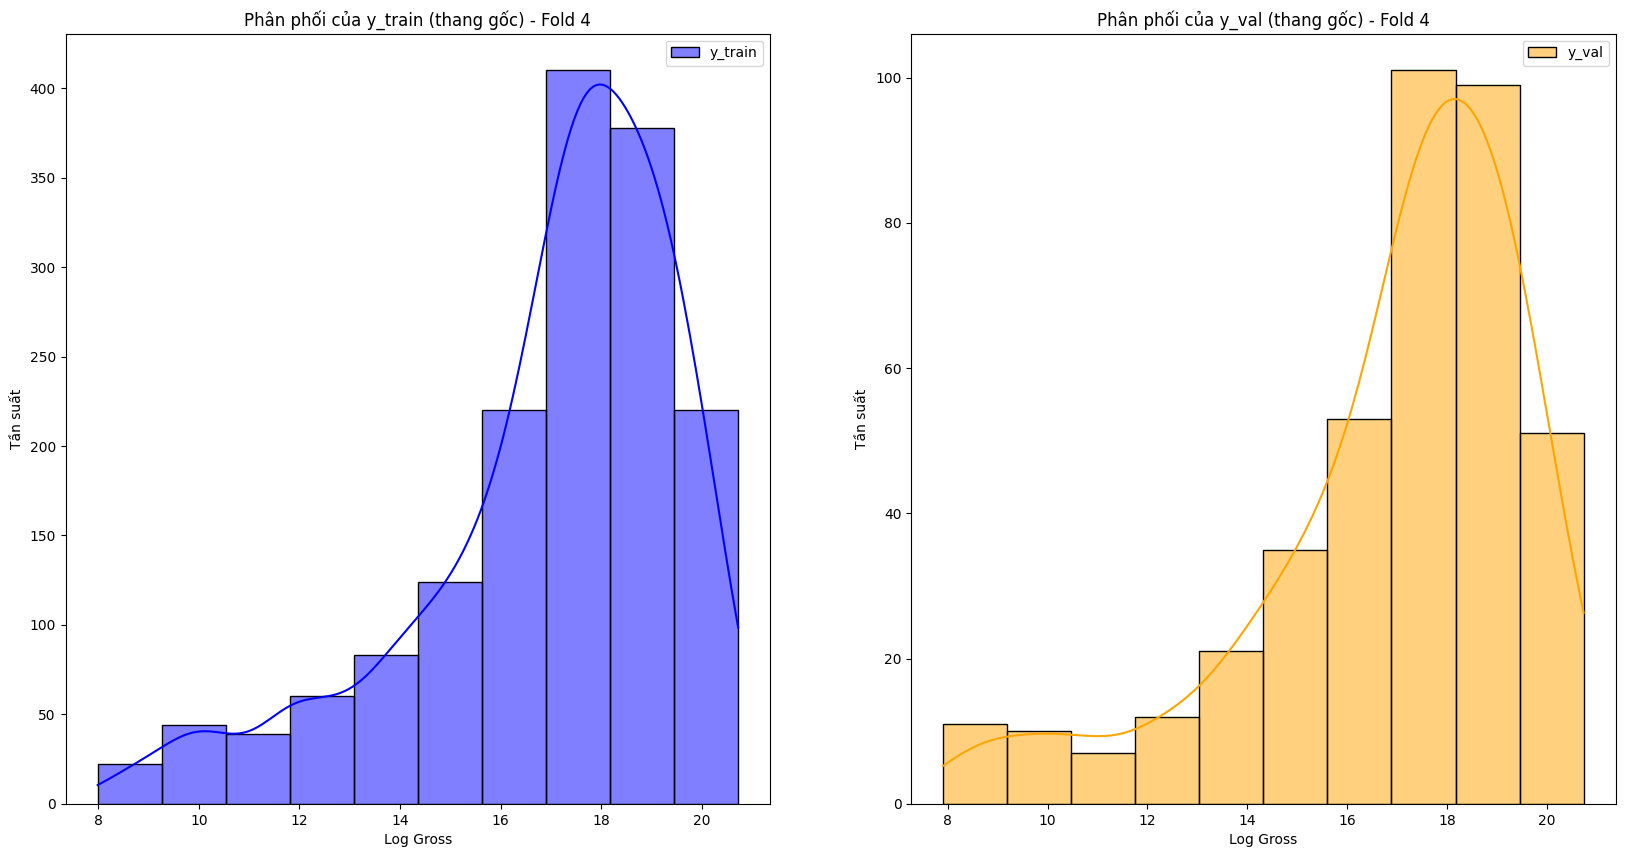

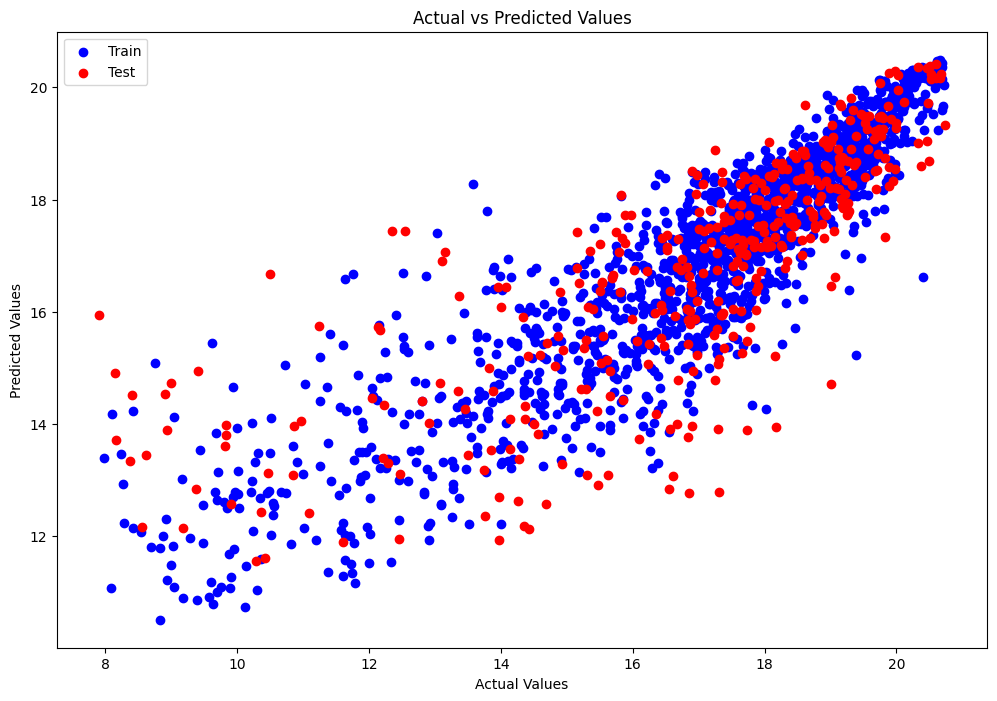

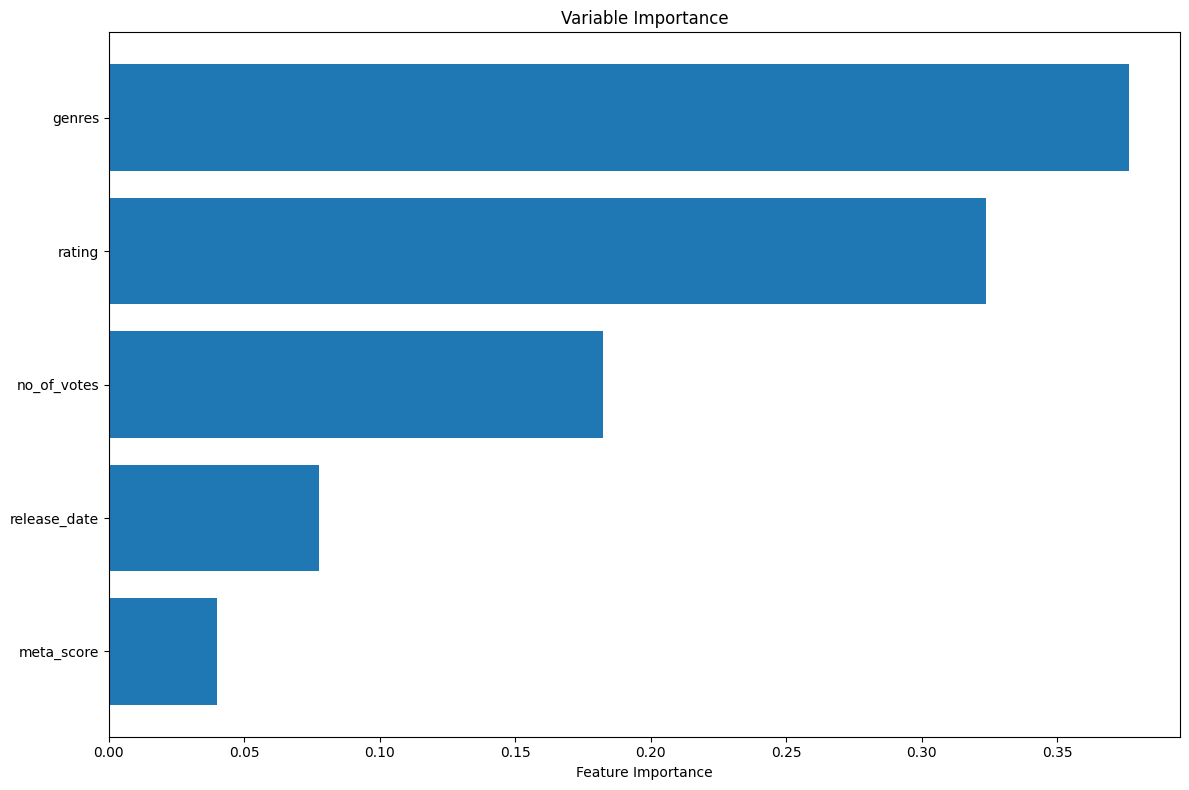


 Fold 5
Fitting 3 folds for each of 96 candidates, totalling 288 fits
 Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Training Metrics
R2 score: 0.7980
MAE: 41,340,713.7031
MAPE: 2.98%
Test Metrics
R2 score: 0.6196
MAE: 58,129,255.6302
MAPE: 7.41%


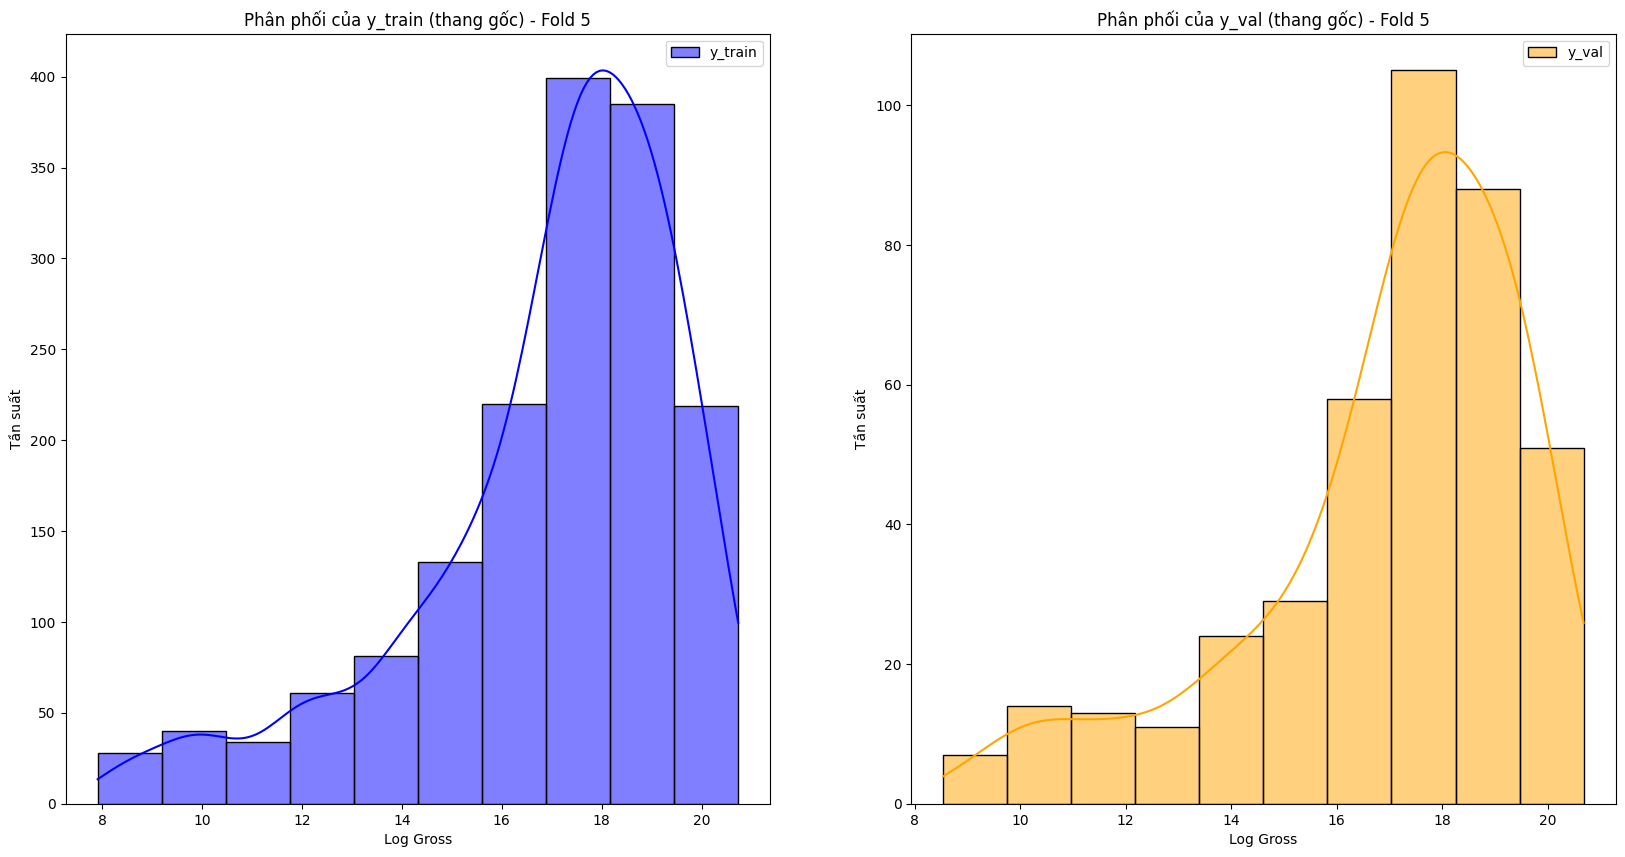

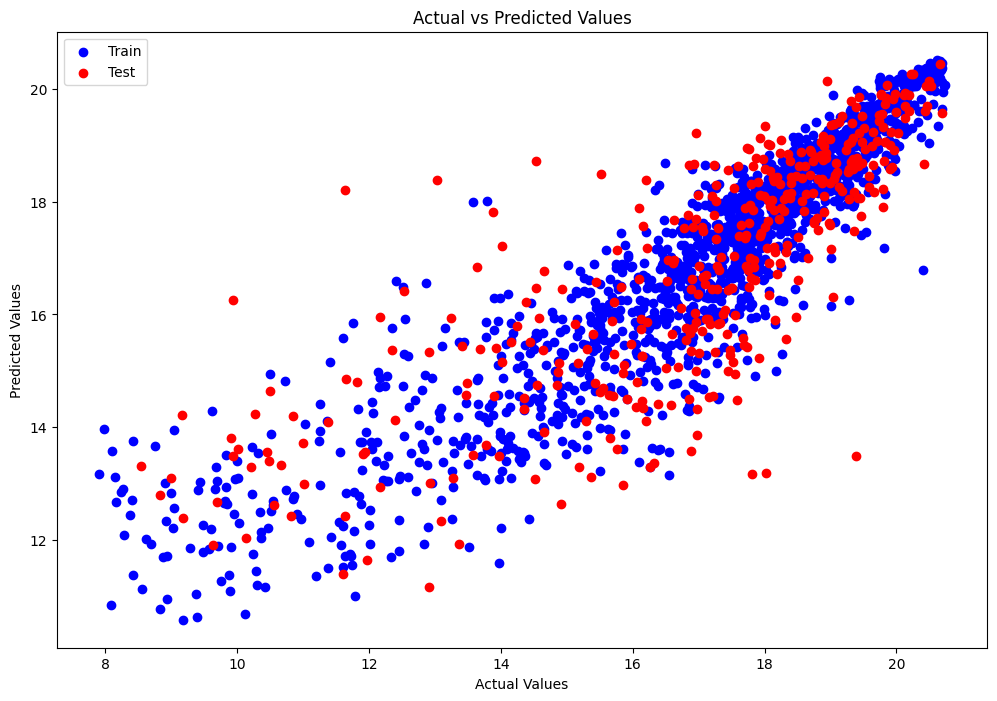

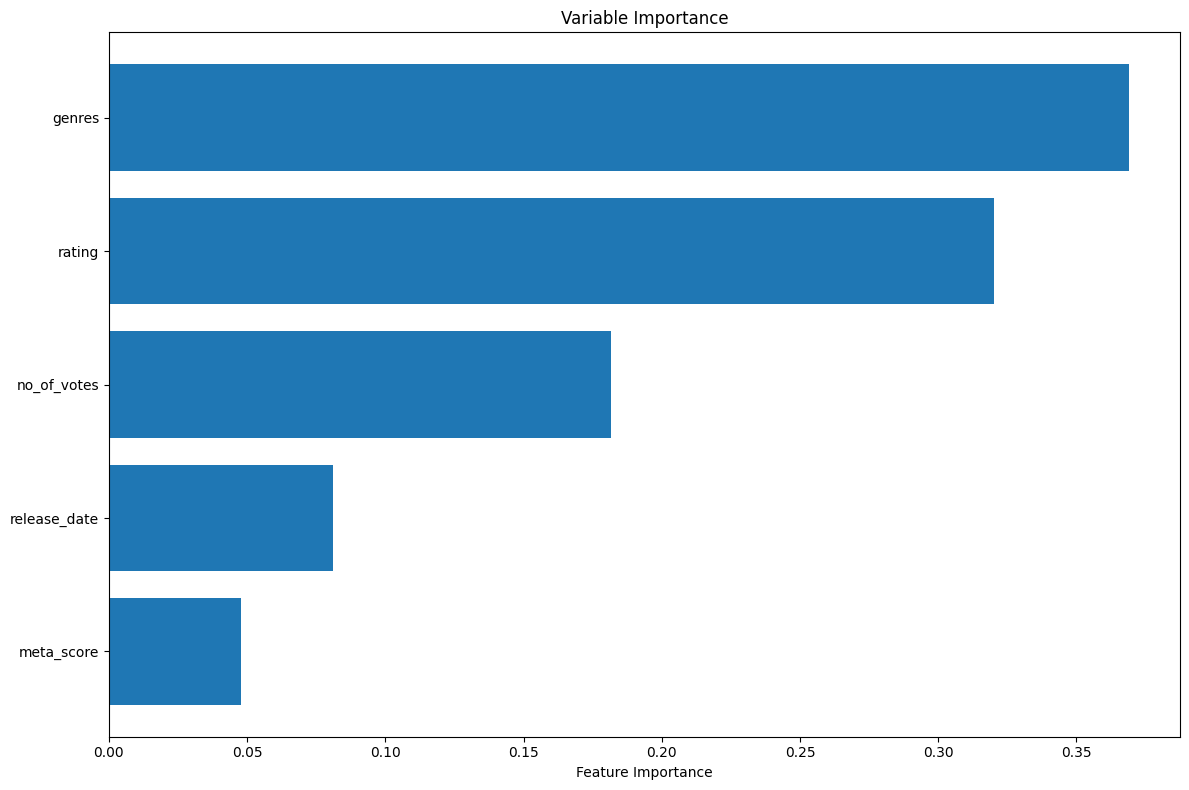

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from save import save_model

param_grid = {
    'n_estimators': [200,300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],                    # Tăng lên để tránh overfitting ở lá rất nhỏ
    'max_features': ['sqrt', 'log2'],             # Số lượng feature được chọn ngẫu nhiên khi split
    'bootstrap': [True, False]                         # False đôi khi giúp giảm bias nhưng tăng variance
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    features = ['log_no_of_votes', 'log_budget',
                'log_genre_stat_feature','log_country_stat_feature','rating']

    target = 'log_gross'


    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    base_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    
    # save_model(model=best_model, model_name="random_forest",fold=fold+1,directory="best_models")
    
    print(" Best hyperparameters:", grid_search.best_params_)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )



 Fold 1
✅ Scaler saved to: H:\python\best_models\random_forest\fold_1\scaler.pkl
Training Metrics
R2 score: 0.6082
MAE: 60,803,346.6647
MAPE: 8.75%
Val Metrics
R2 score: 0.5320
MAE: 60,734,001.8455
MAPE: 6.37%


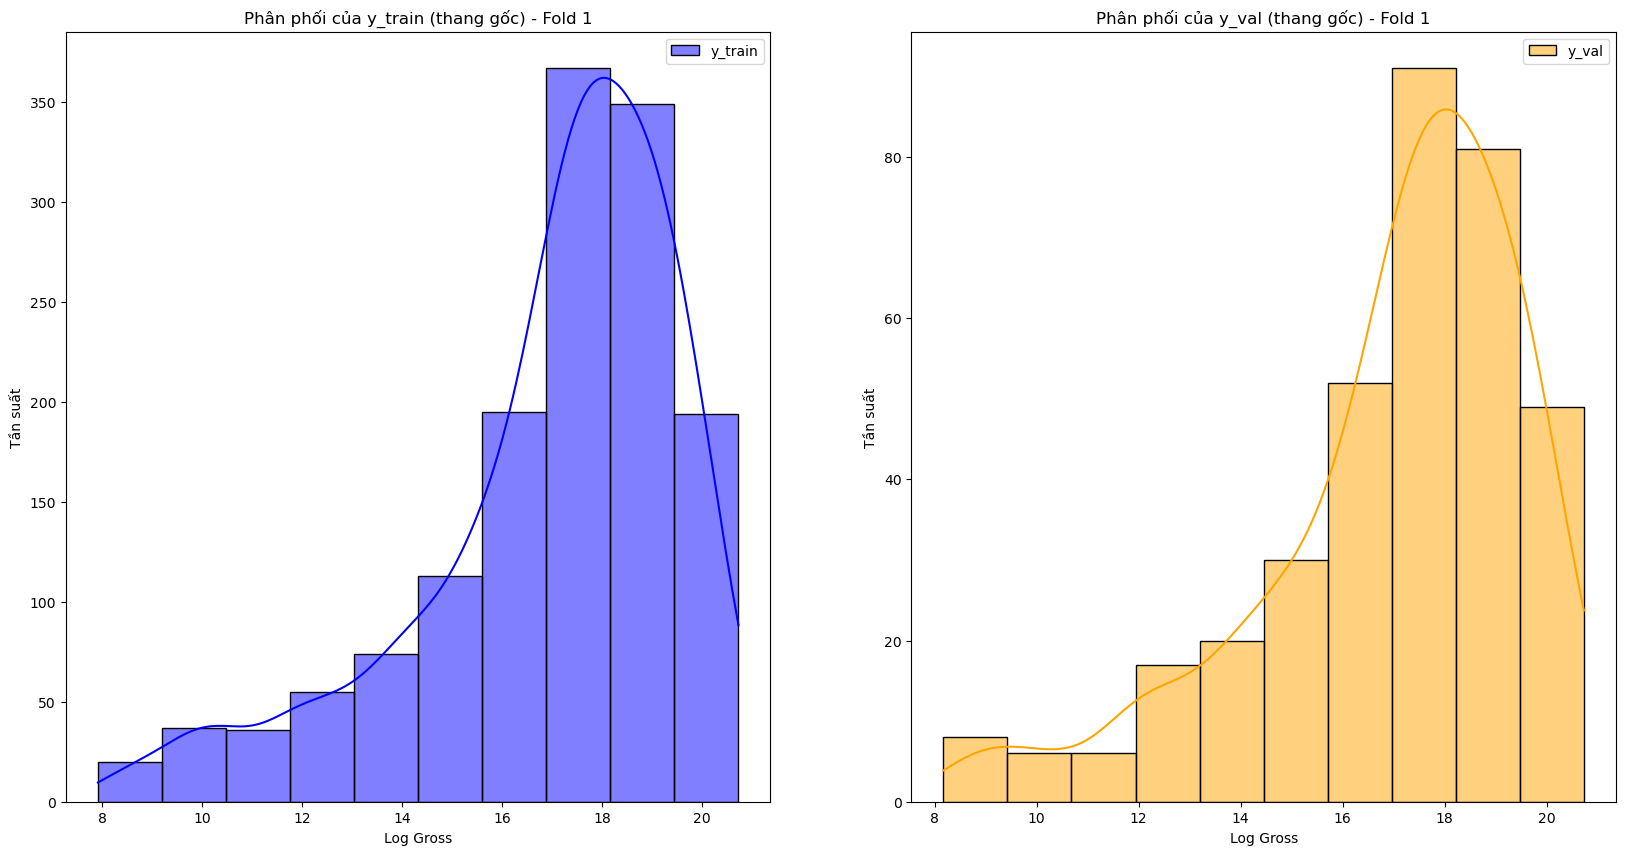

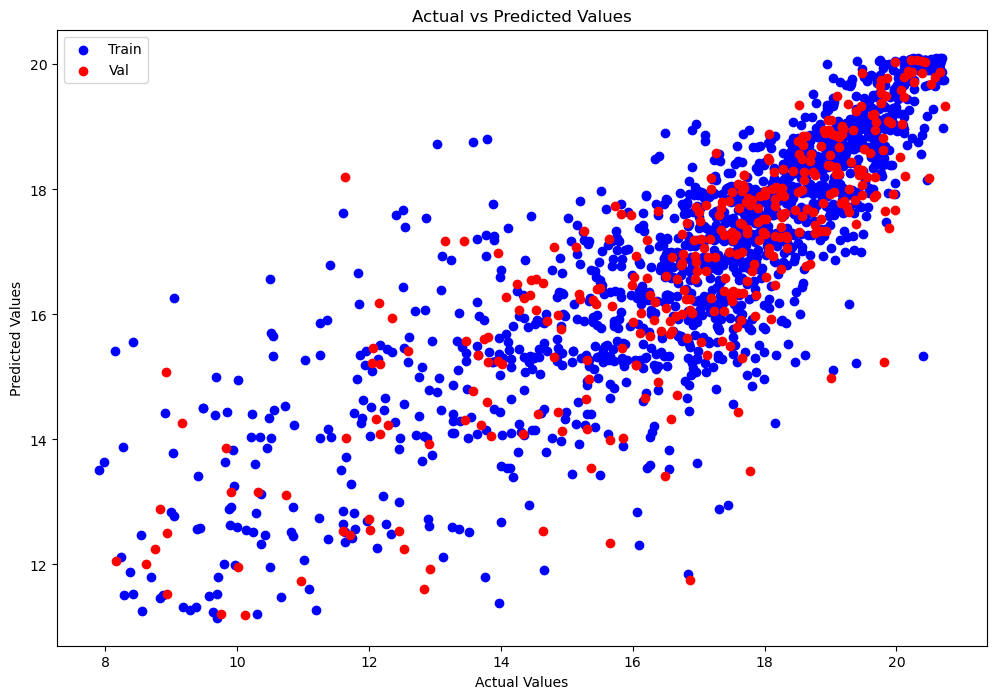

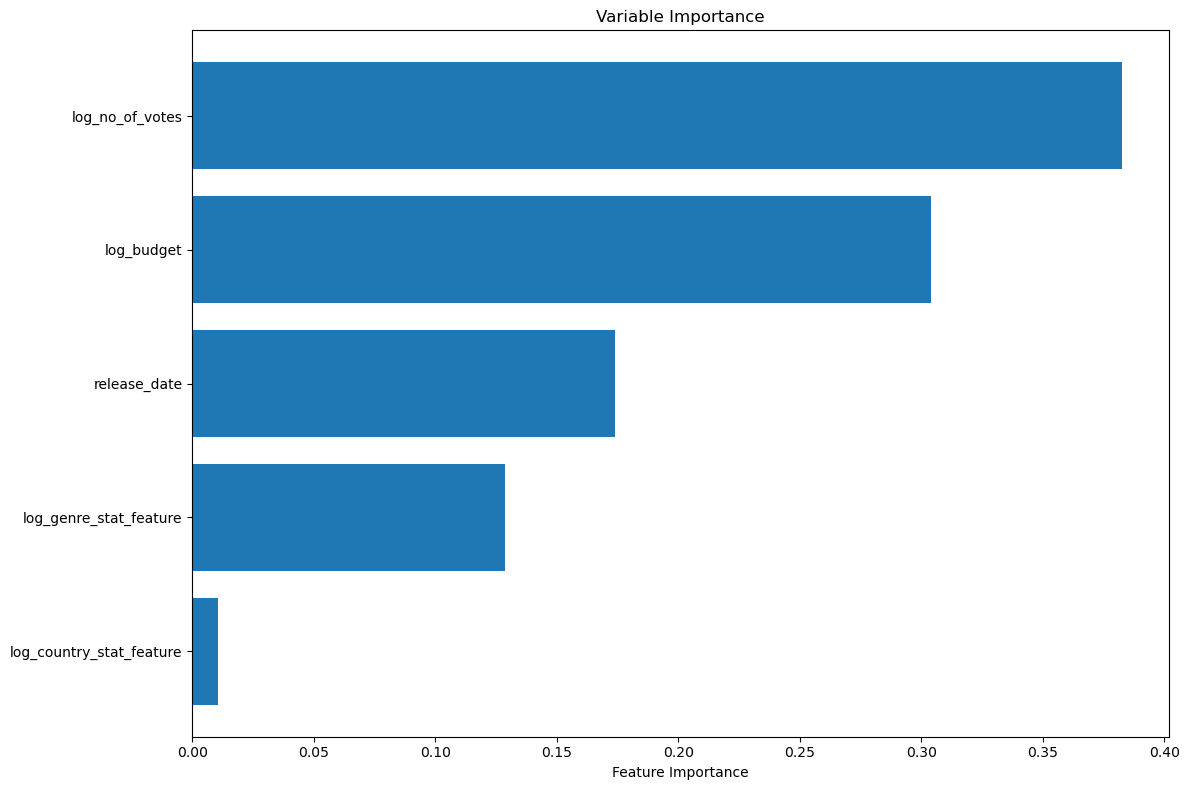


 Fold 2
✅ Scaler saved to: H:\python\best_models\random_forest\fold_2\scaler.pkl
Training Metrics
R2 score: 0.5938
MAE: 59,342,959.6169
MAPE: 8.47%
Val Metrics
R2 score: 0.5557
MAE: 67,656,273.9202
MAPE: 6.91%


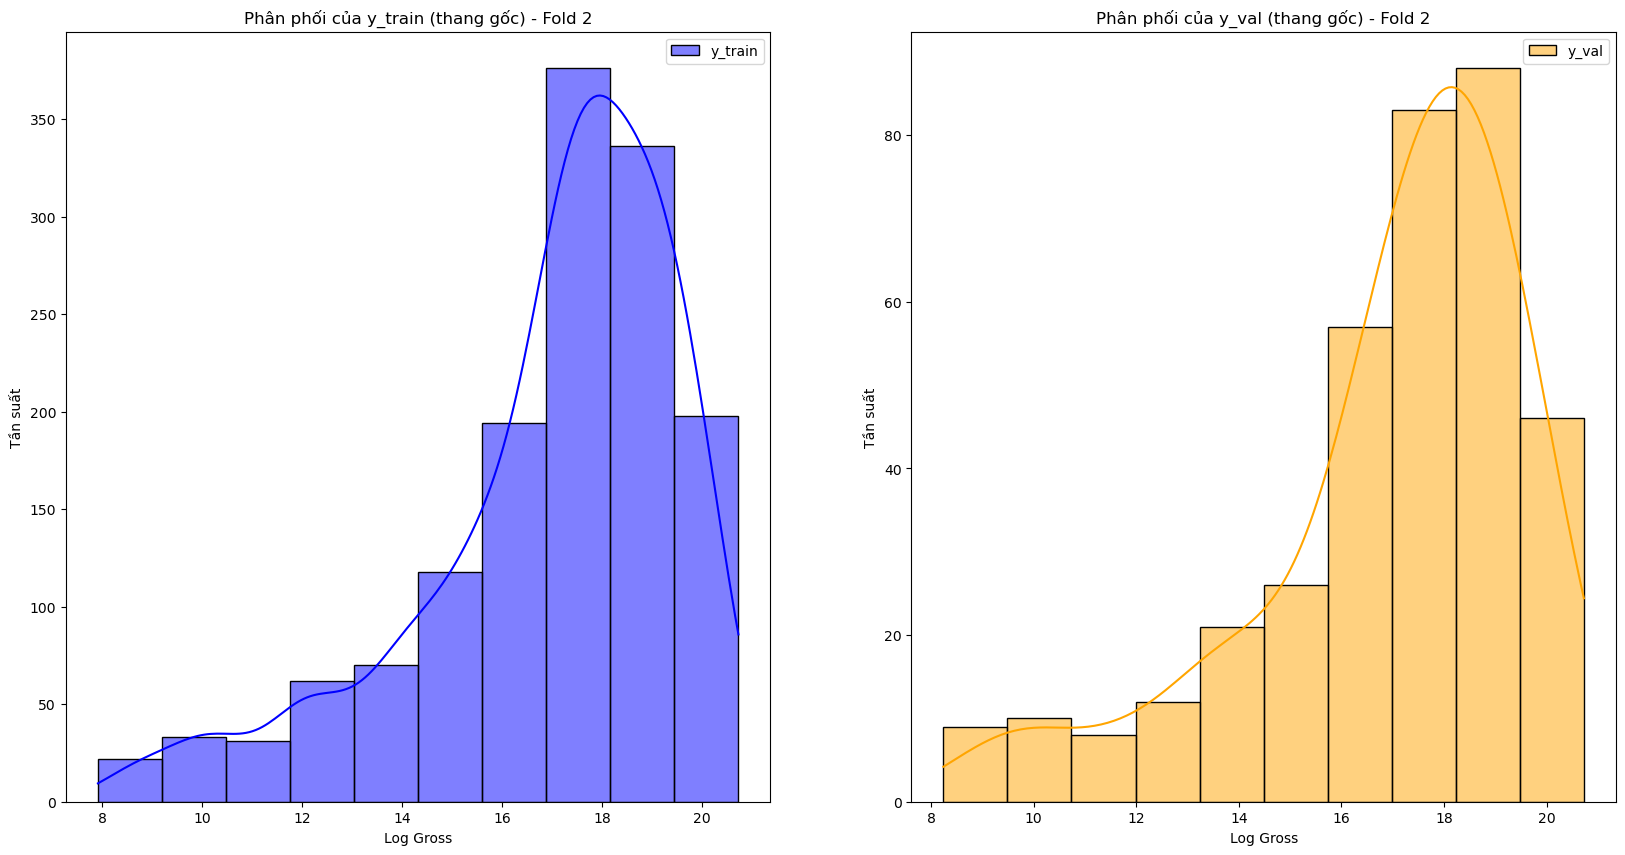

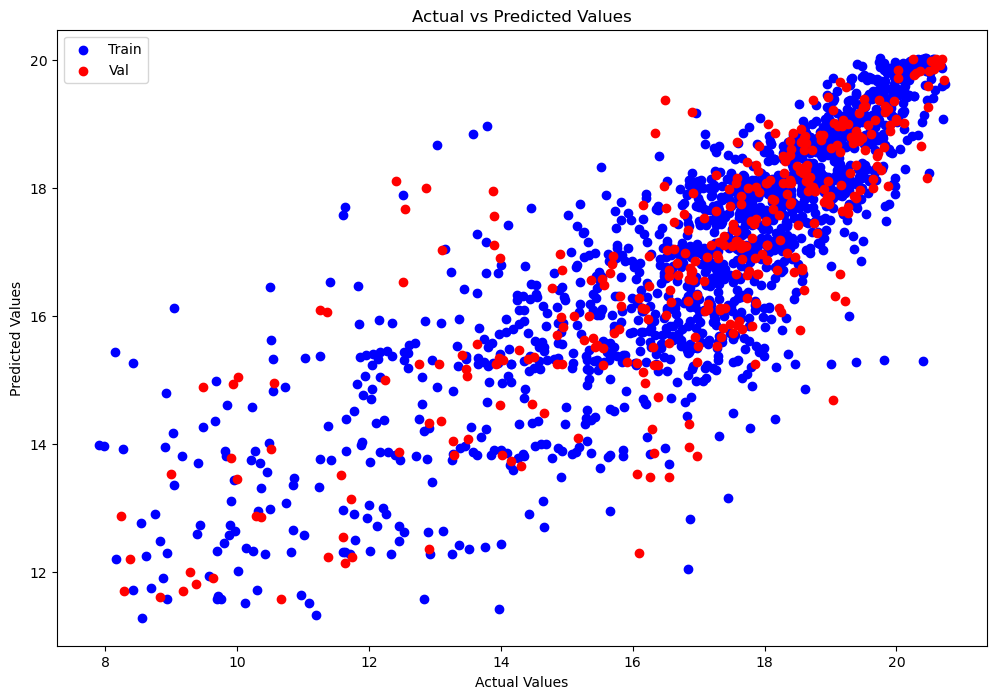

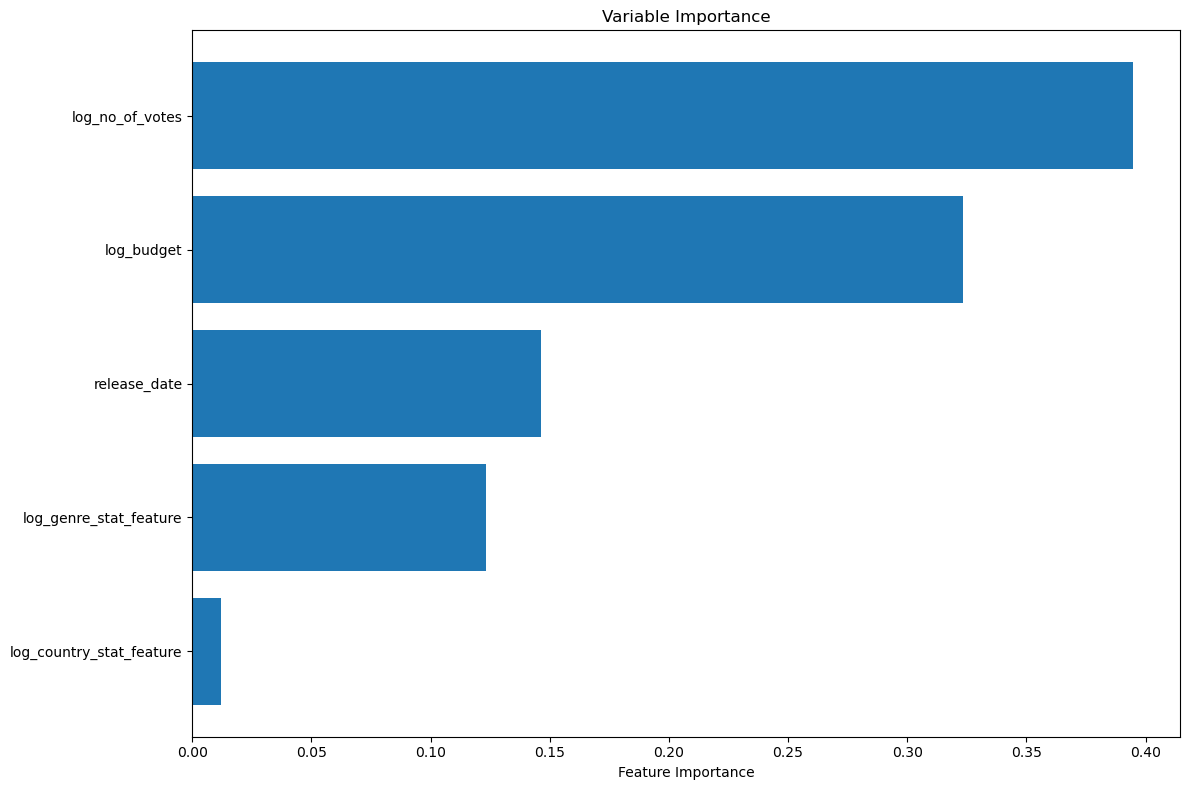


 Fold 3
✅ Scaler saved to: H:\python\best_models\random_forest\fold_3\scaler.pkl
Training Metrics
R2 score: 0.6053
MAE: 59,743,304.6627
MAPE: 7.36%
Val Metrics
R2 score: 0.5594
MAE: 65,310,360.3592
MAPE: 14.24%


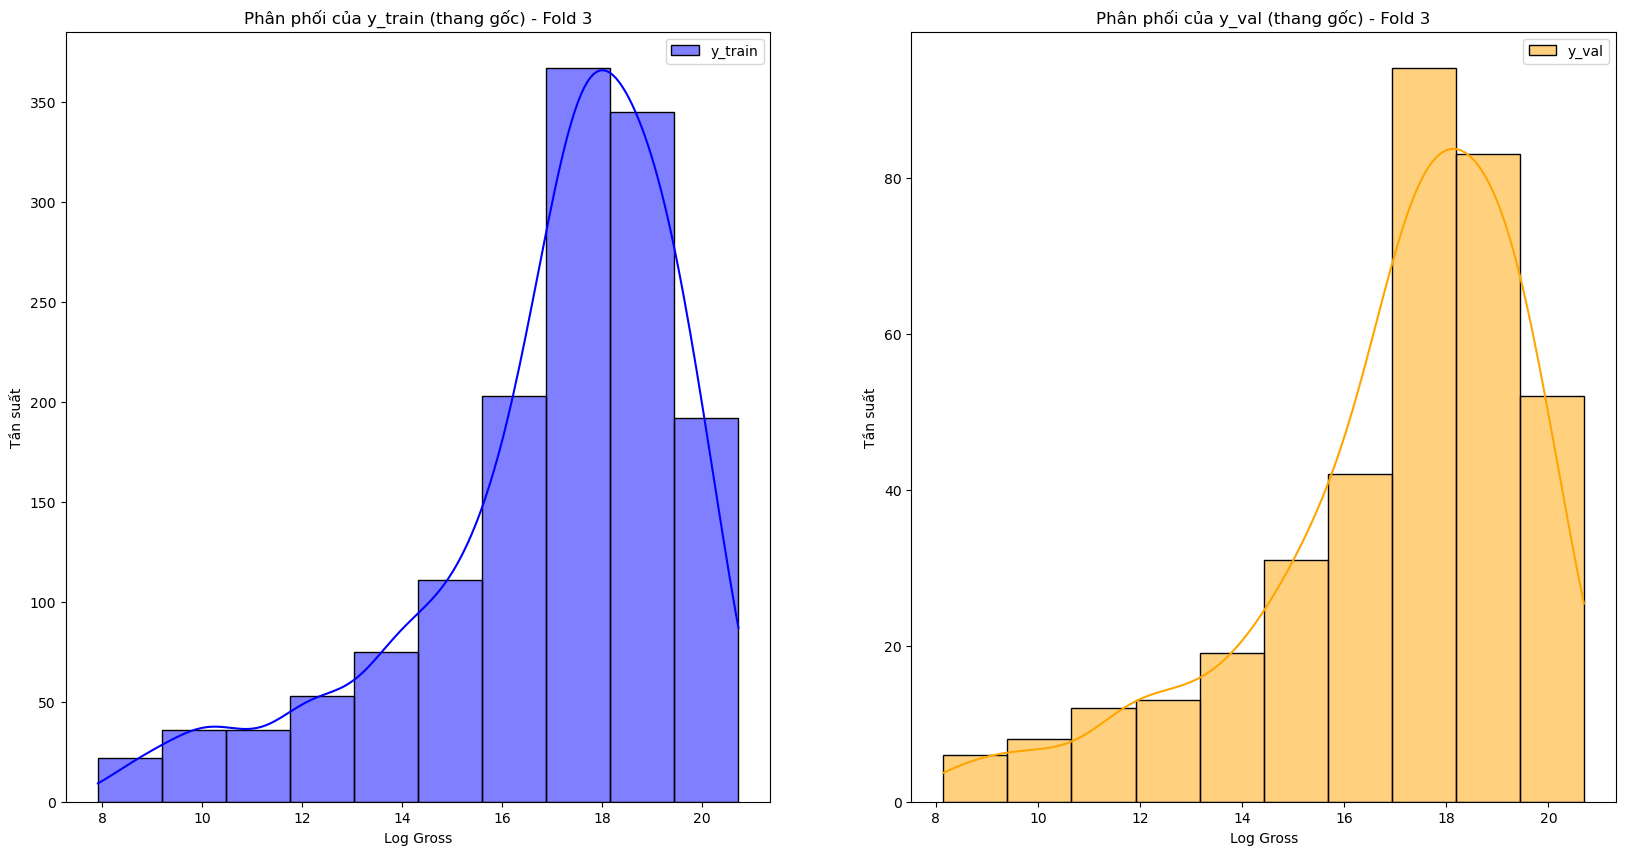

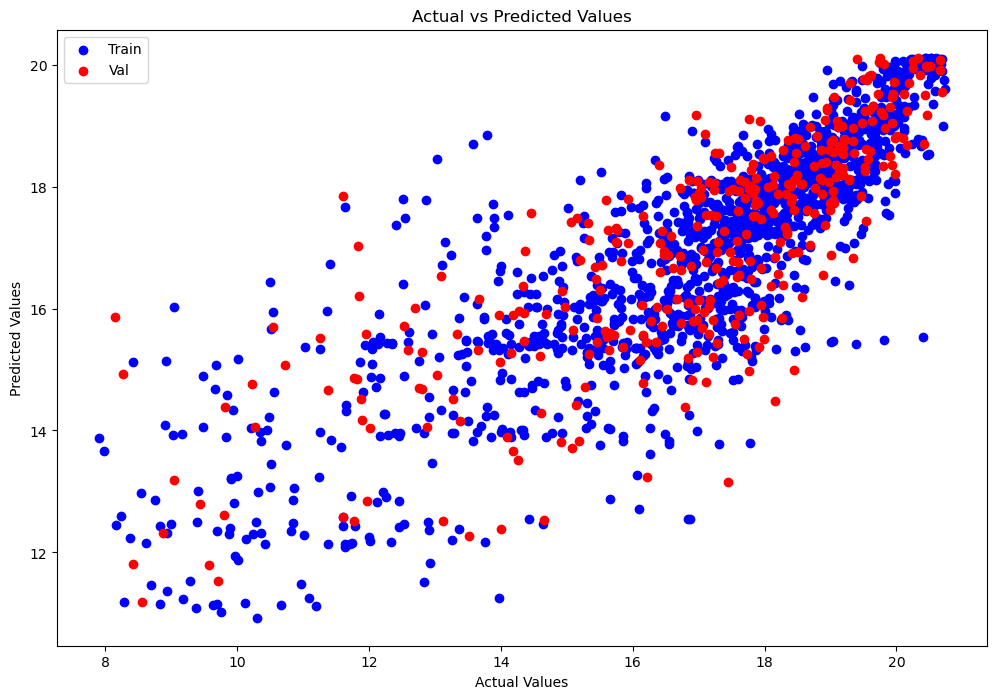

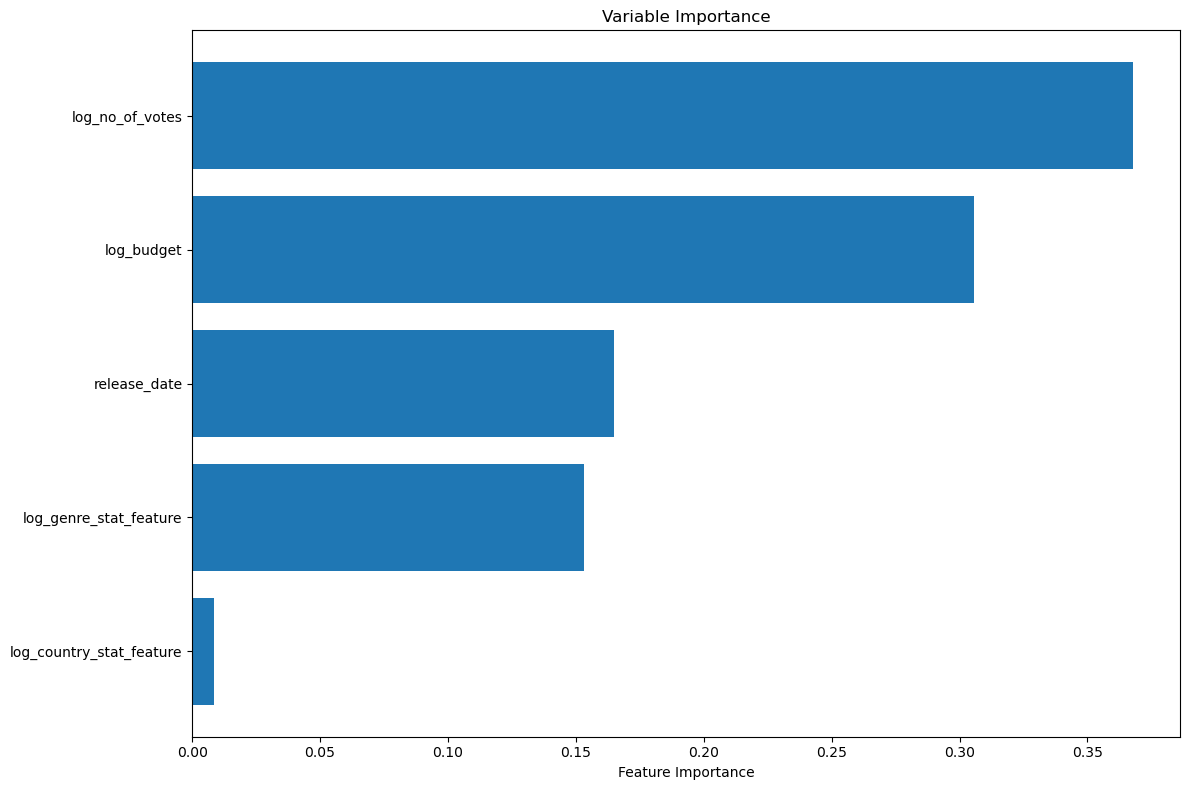


 Fold 4
✅ Scaler saved to: H:\python\best_models\random_forest\fold_4\scaler.pkl
Training Metrics
R2 score: 0.6240
MAE: 58,481,600.8636
MAPE: 5.53%
Val Metrics
R2 score: 0.5201
MAE: 67,182,485.5125
MAPE: 22.00%


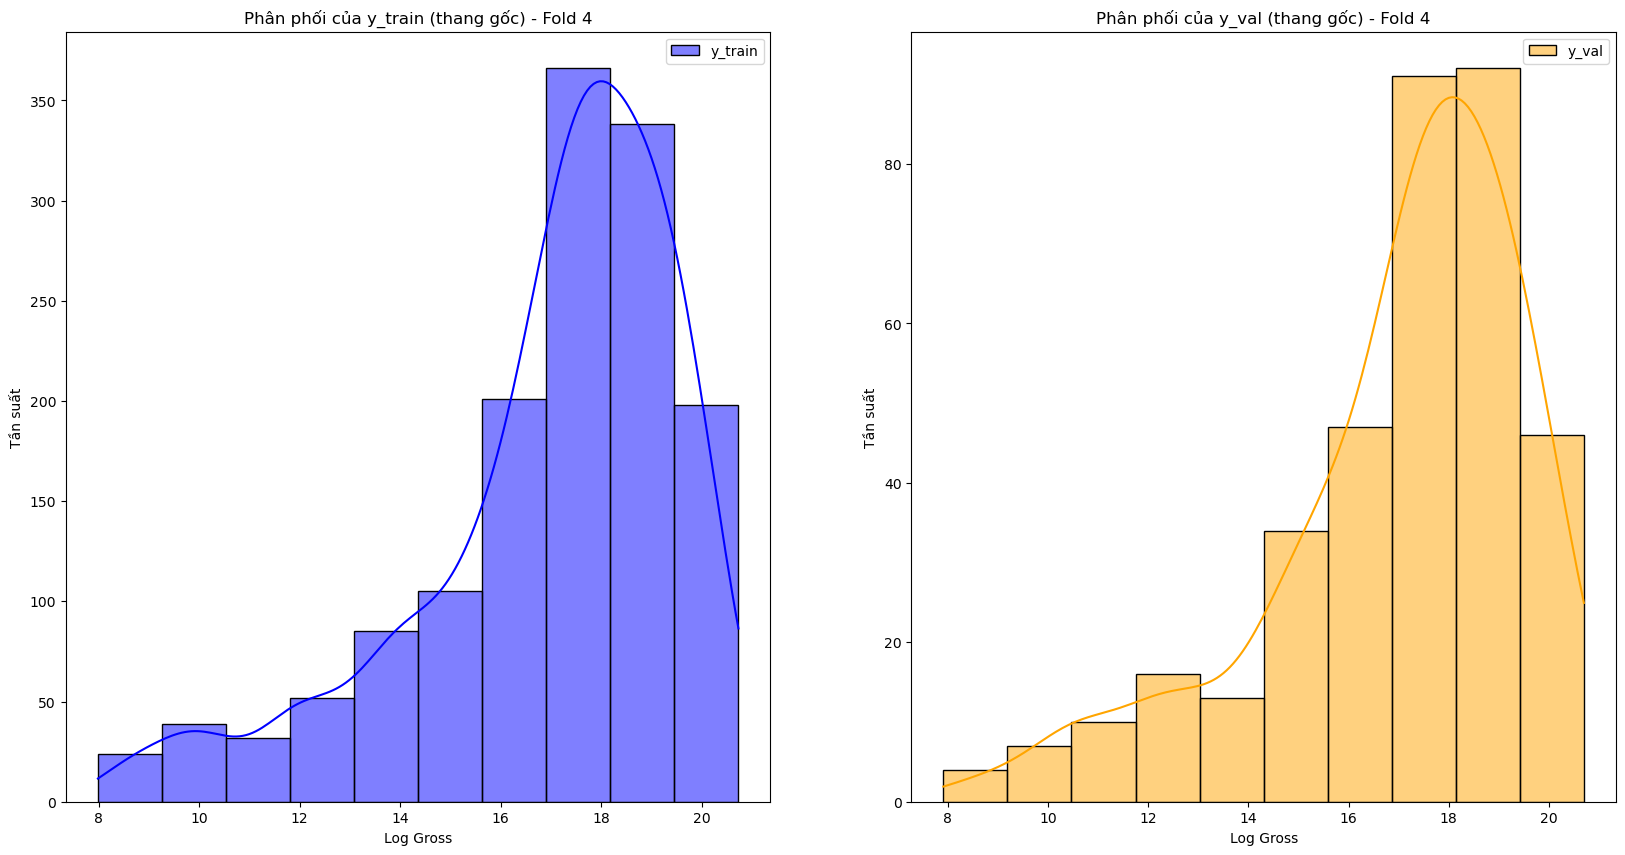

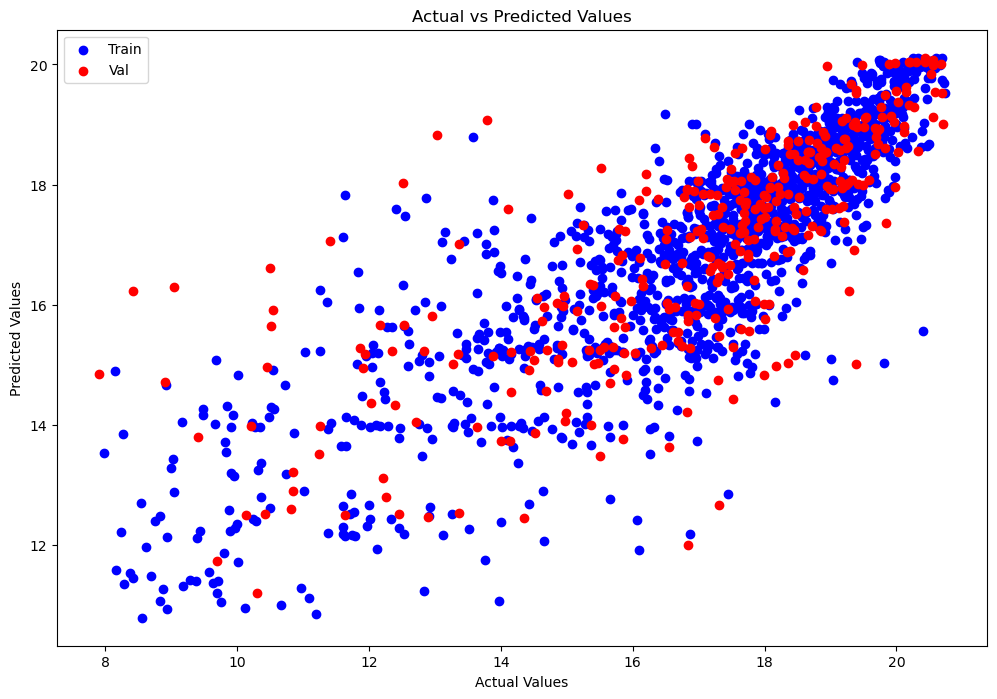

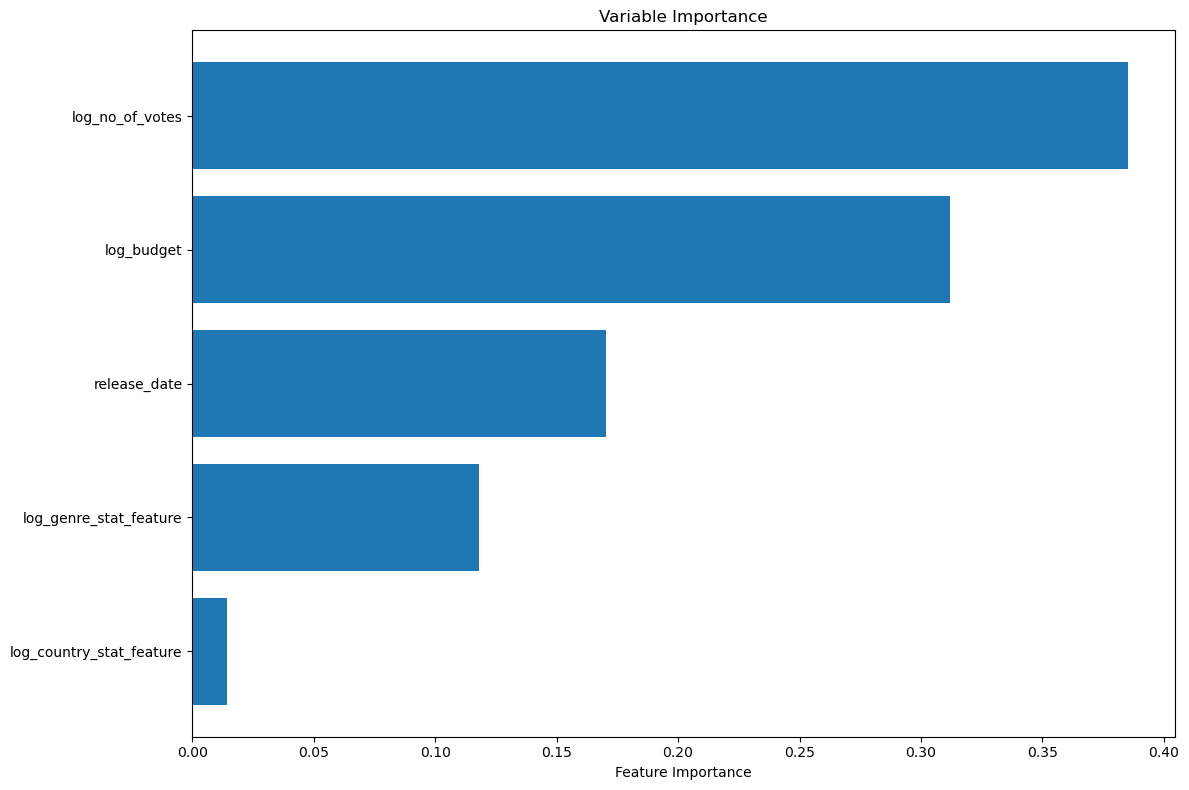


 Fold 5
✅ Scaler saved to: H:\python\best_models\random_forest\fold_5\scaler.pkl
Training Metrics
R2 score: 0.6030
MAE: 61,009,546.7657
MAPE: 8.46%
Val Metrics
R2 score: 0.6010
MAE: 58,970,796.0782
MAPE: 10.27%


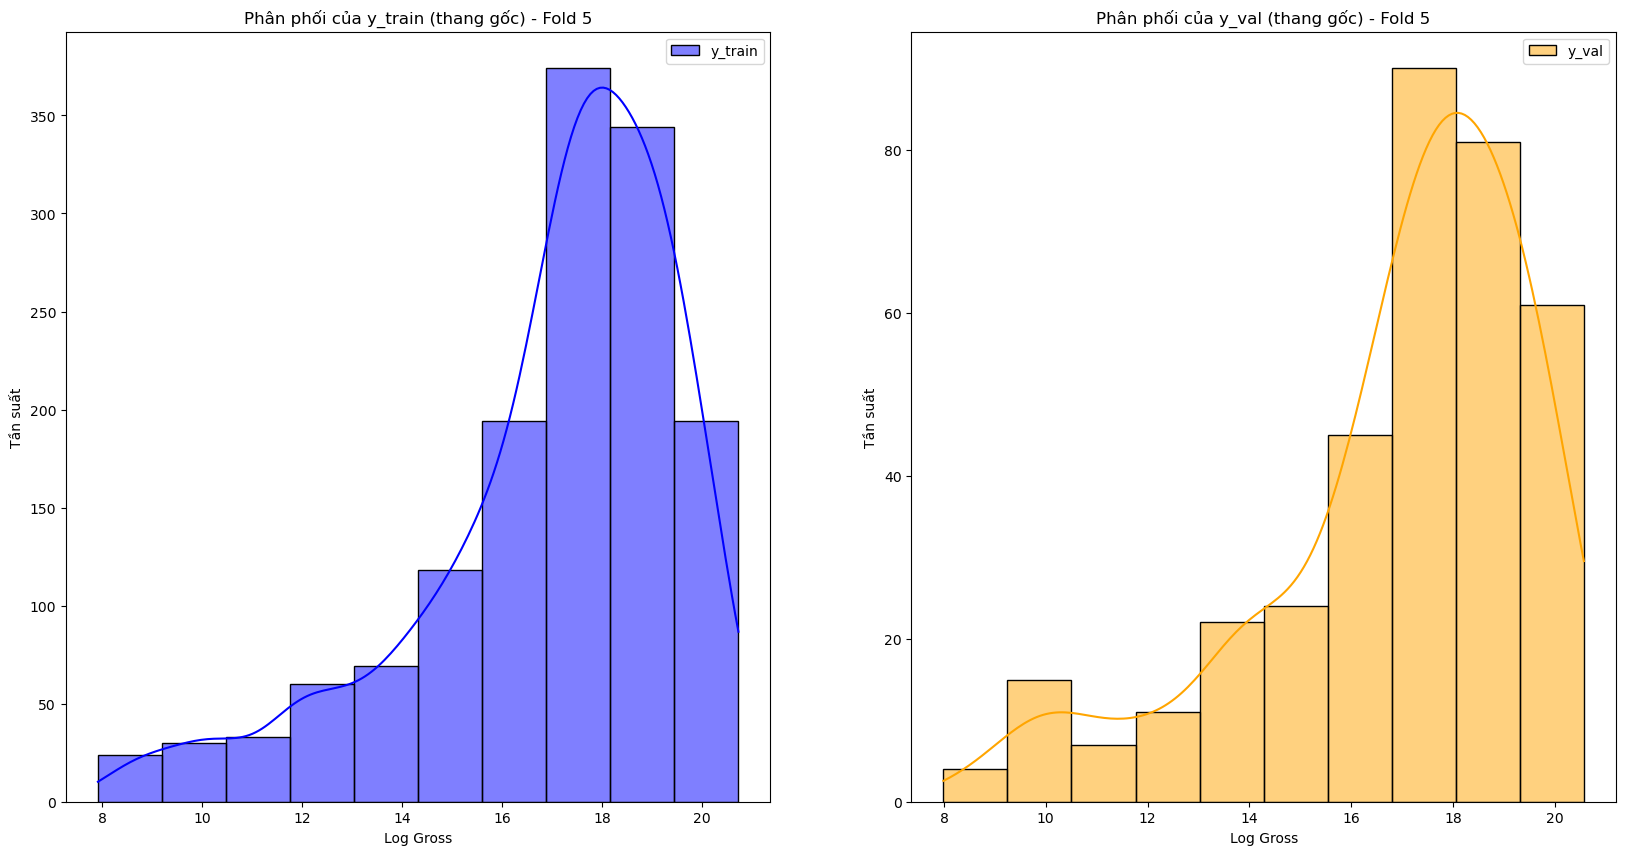

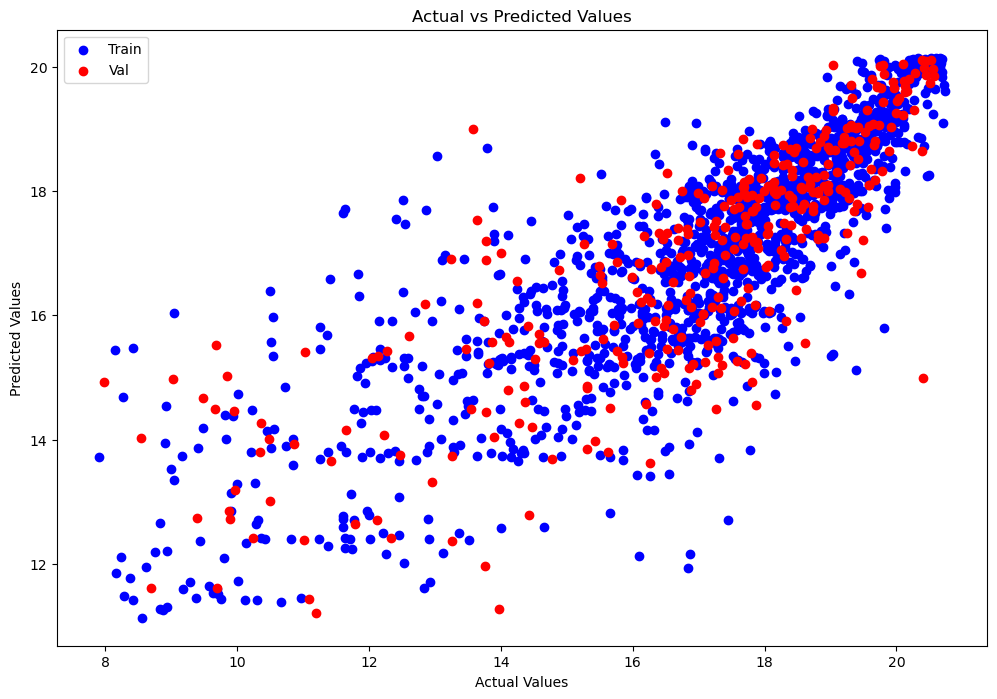

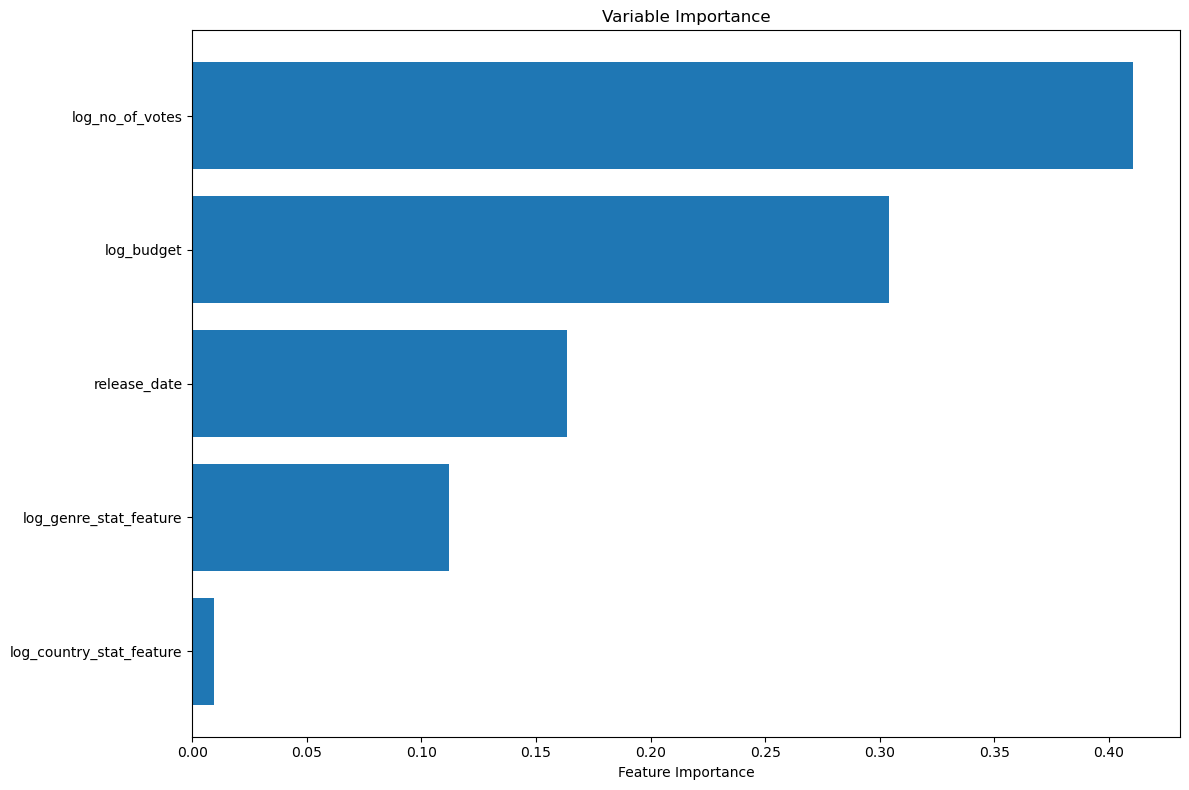

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from settings import FEATURES, TARGET


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=FEATURES, target=TARGET, model_name="random_forest")

    best_model = RandomForestRegressor(random_state=42, bootstrap=True, min_samples_leaf=10, min_samples_split=10, n_estimators=100, max_depth=5, max_samples=0.8, max_features="sqrt")
    best_model.fit(X_train, y_train)

    

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    df_train_processed = pd.DataFrame(X_train, columns=FEATURES)
    df_train_processed[TARGET] = y_train

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df_train_processed,
        calculate_real_target=True,
    )


#### Thư viện Optuna


Fold 1
 Best hyperparameters: {'n_estimators': 219, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.490172278626588
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8489
MAE: 34,068,352.0442
MAPE: 1.22%
Test Metrics
R2 score: 0.6017
MAE: 62,668,626.7987
MAPE: 10.25%


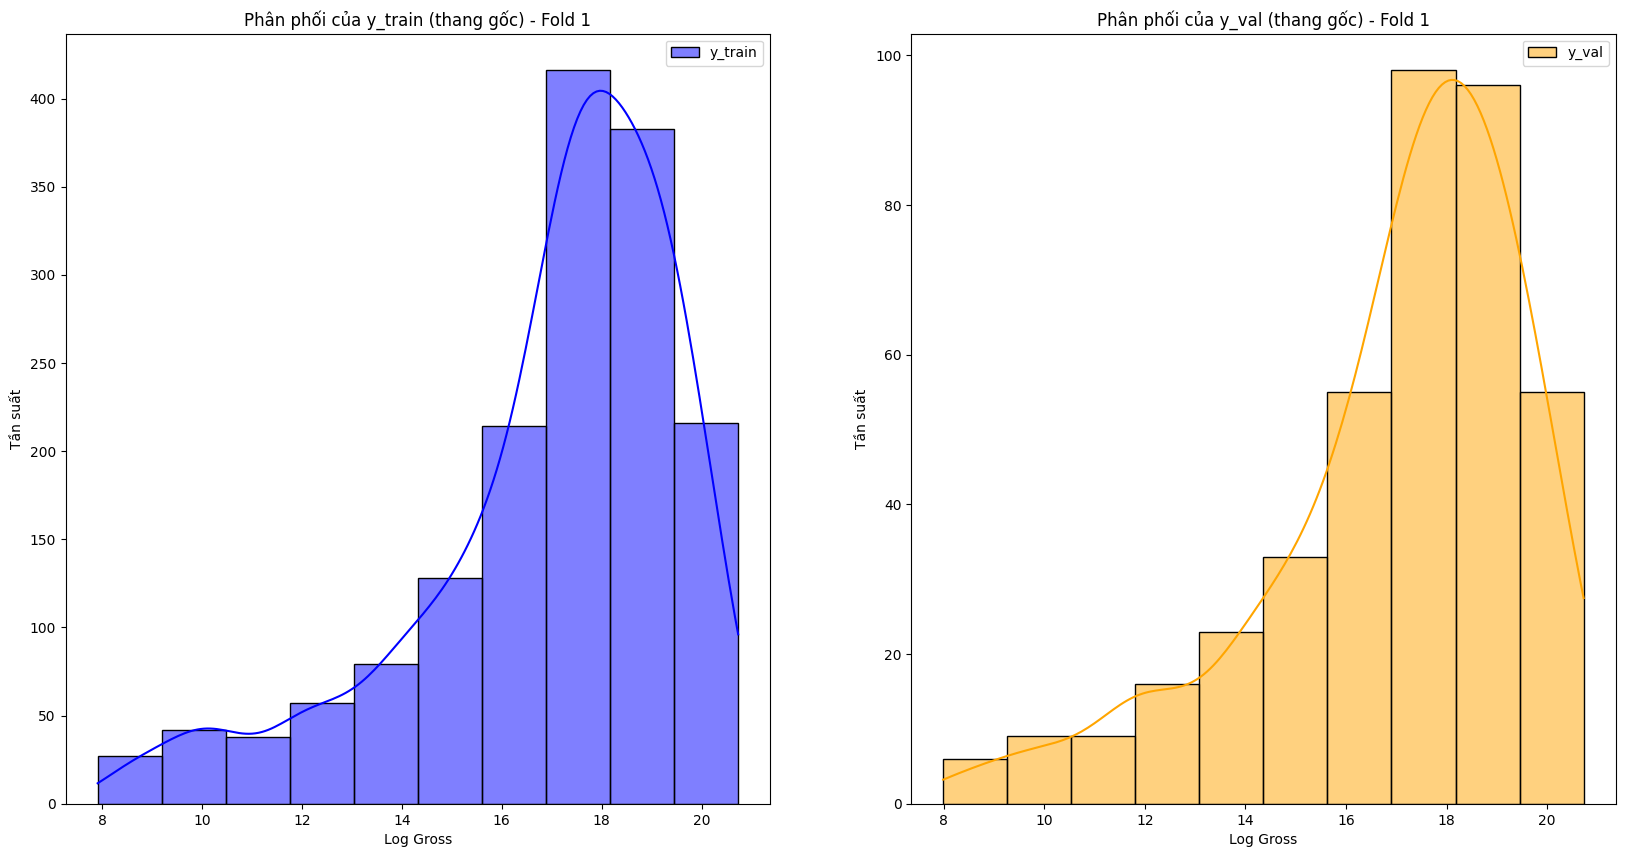

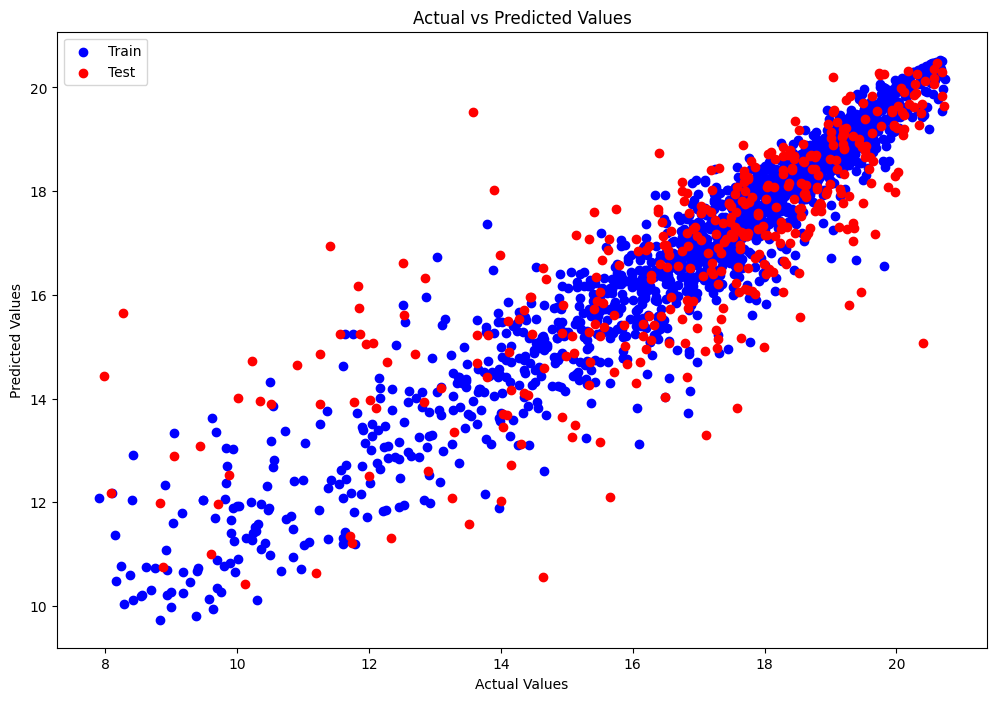

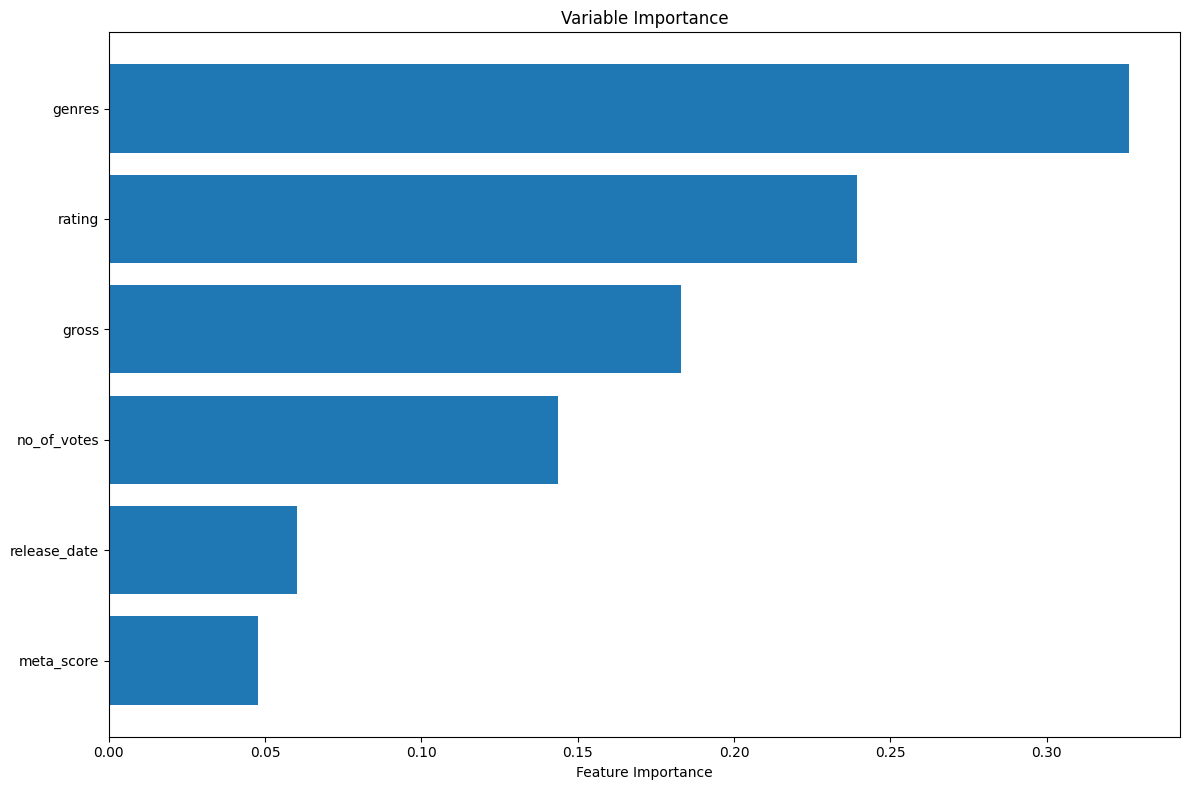


Fold 2
 Best hyperparameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.5237134006091897
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7527
MAE: 46,958,391.5045
MAPE: 3.09%
Test Metrics
R2 score: 0.5832
MAE: 64,628,264.6972
MAPE: 11.11%


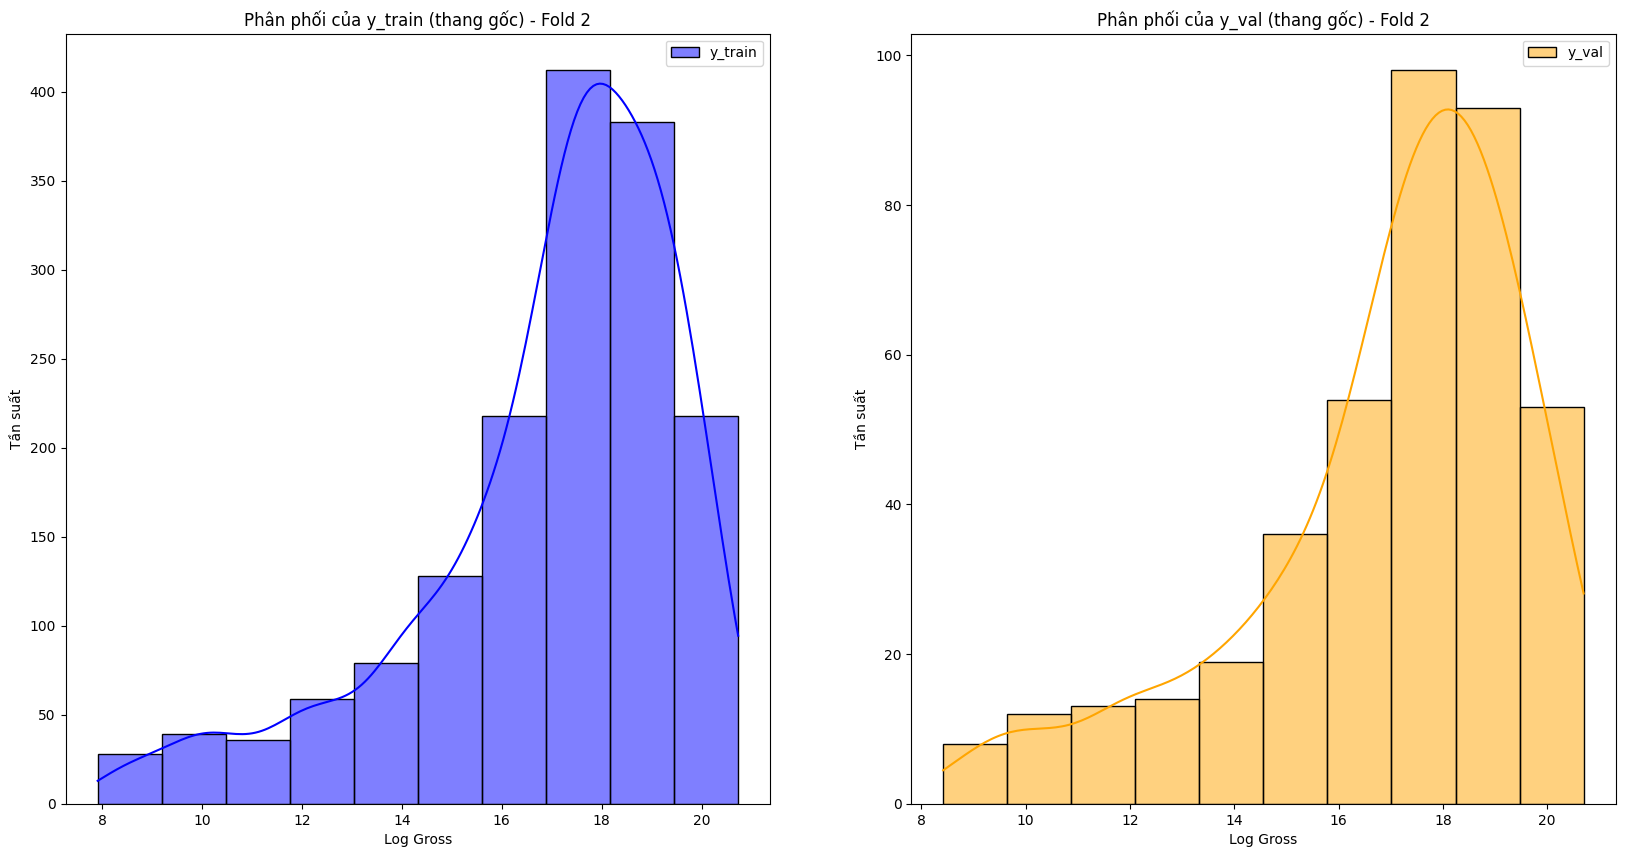

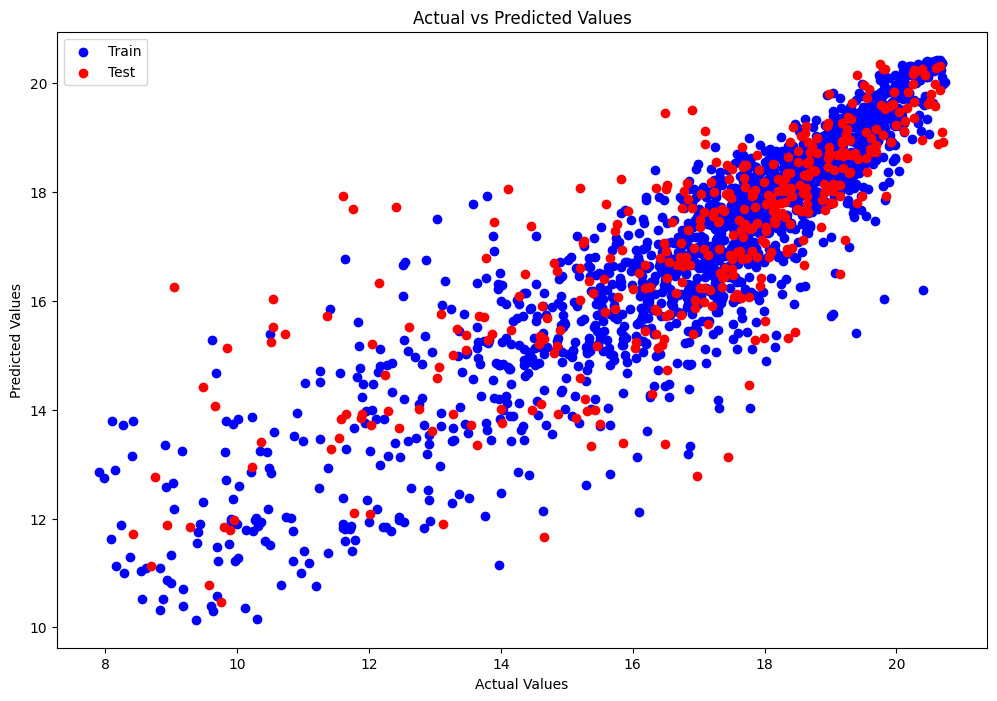

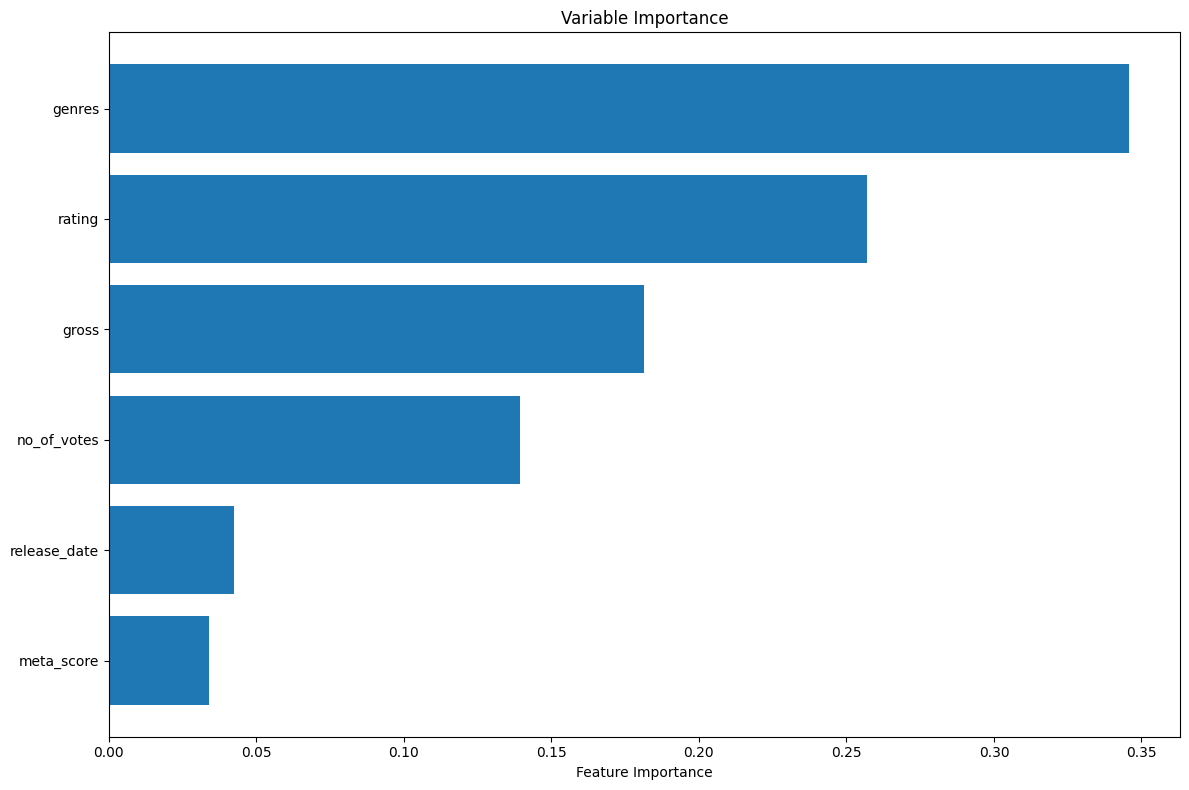


Fold 3
 Best hyperparameters: {'n_estimators': 333, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.360854331495268
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8417
MAE: 34,915,582.1289
MAPE: 1.21%
Test Metrics
R2 score: 0.6925
MAE: 56,747,852.8386
MAPE: 21.20%


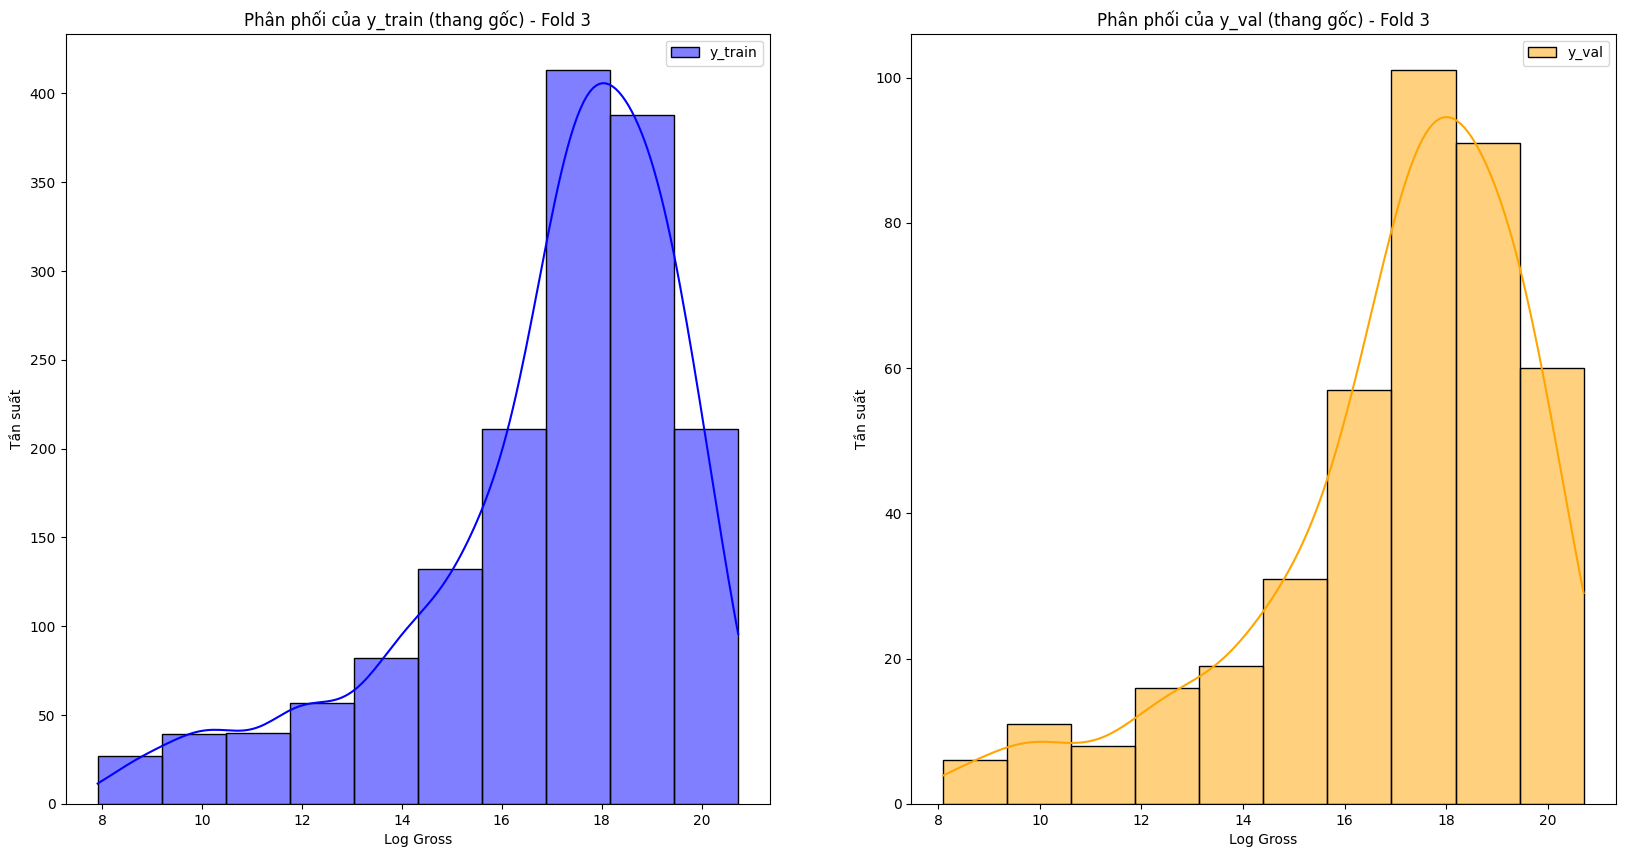

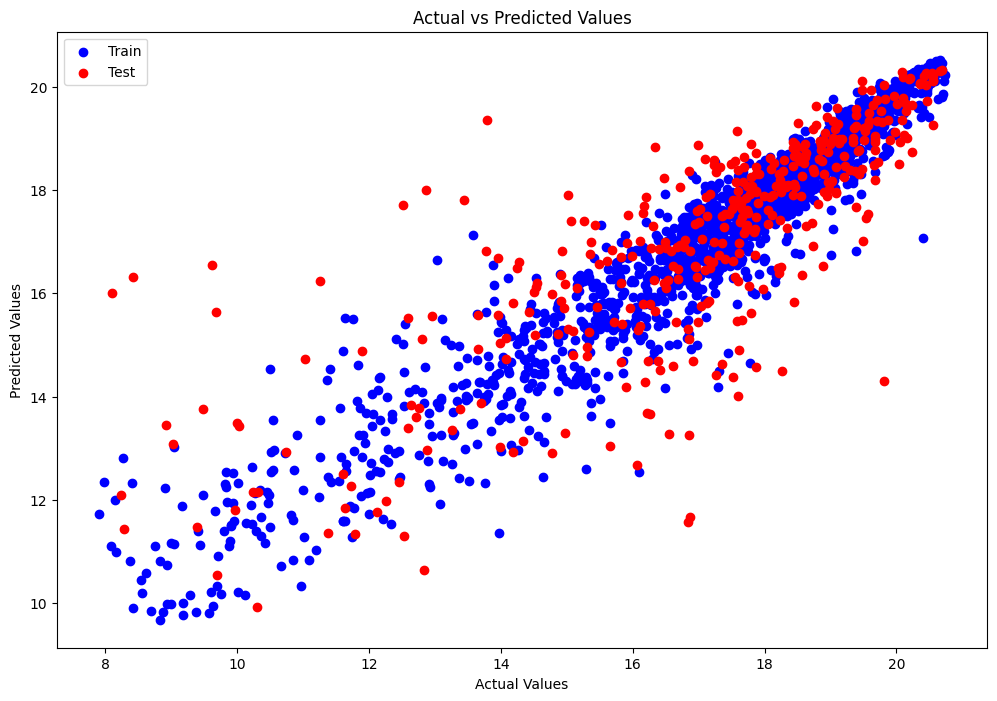

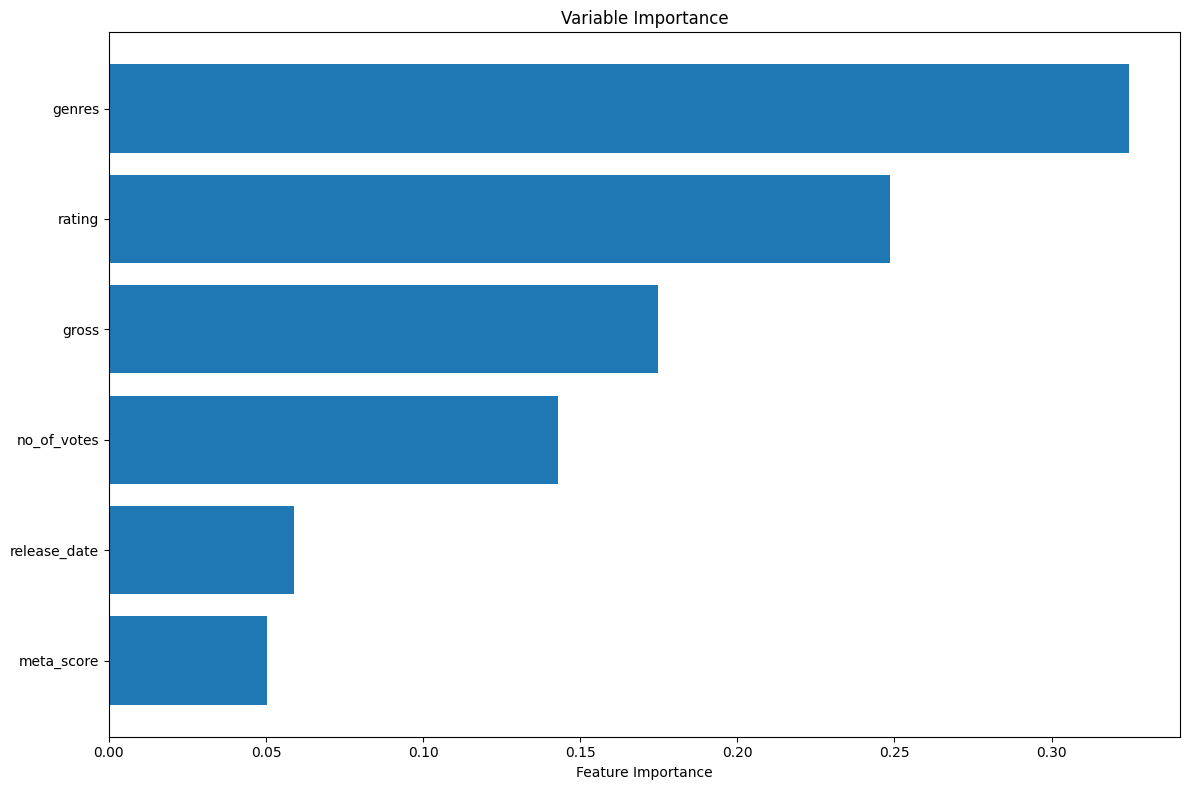


Fold 4
 Best hyperparameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.545511410428418
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7390
MAE: 47,964,890.3720
MAPE: 3.31%
Test Metrics
R2 score: 0.6011
MAE: 59,701,026.2738
MAPE: 11.15%


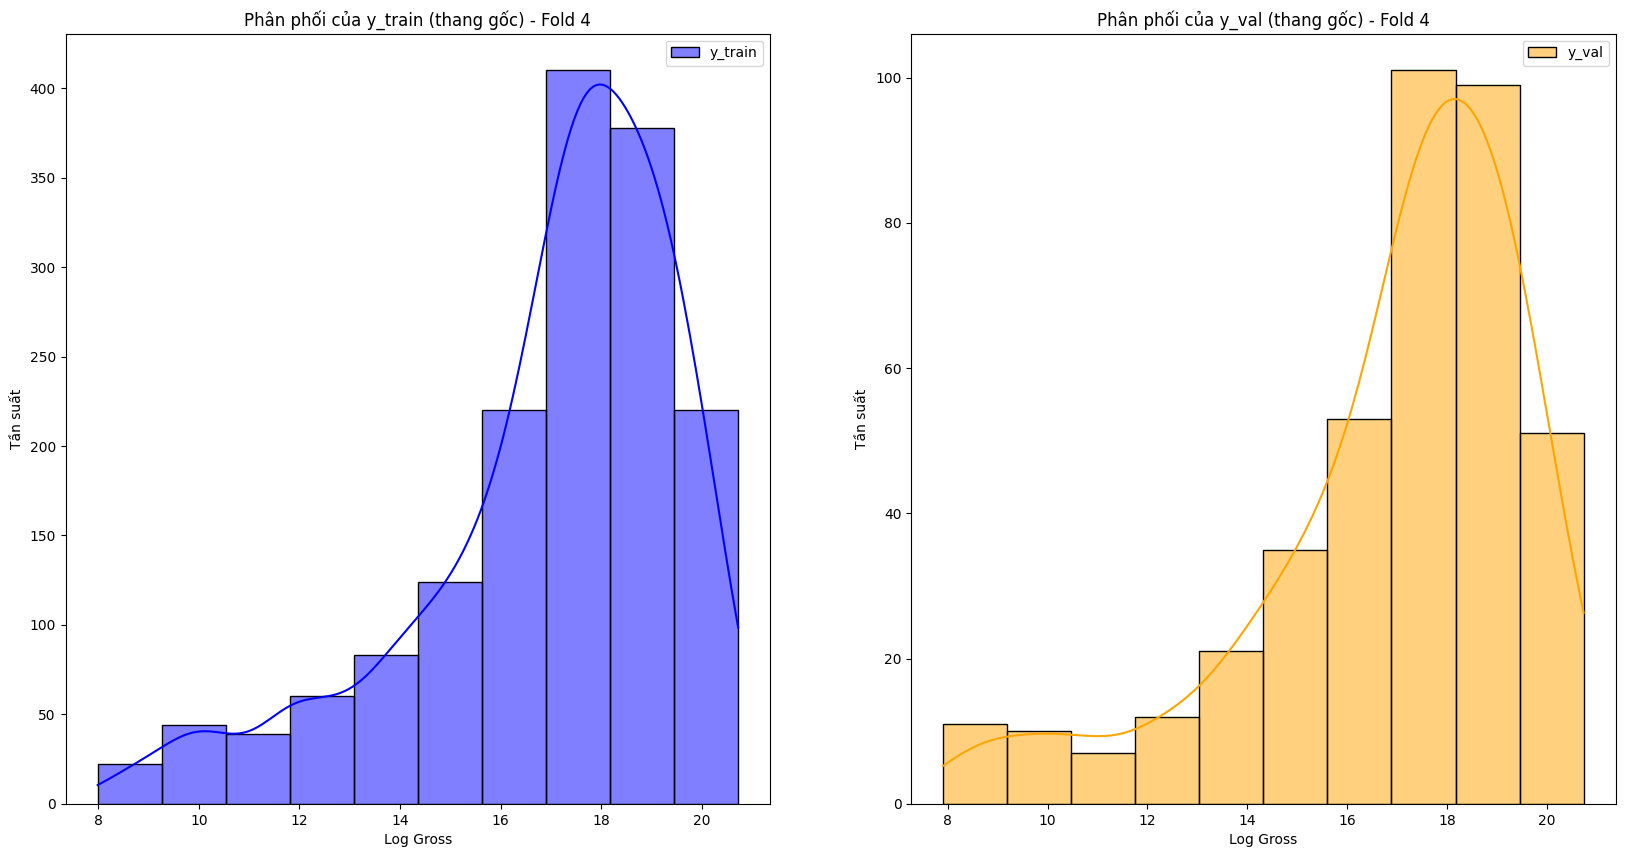

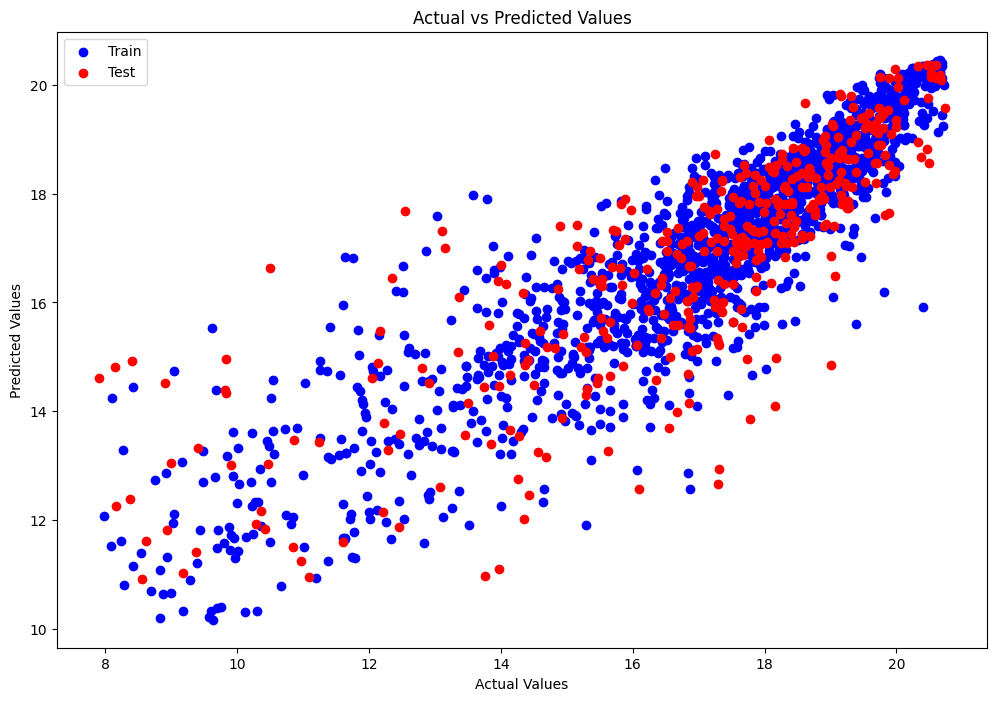

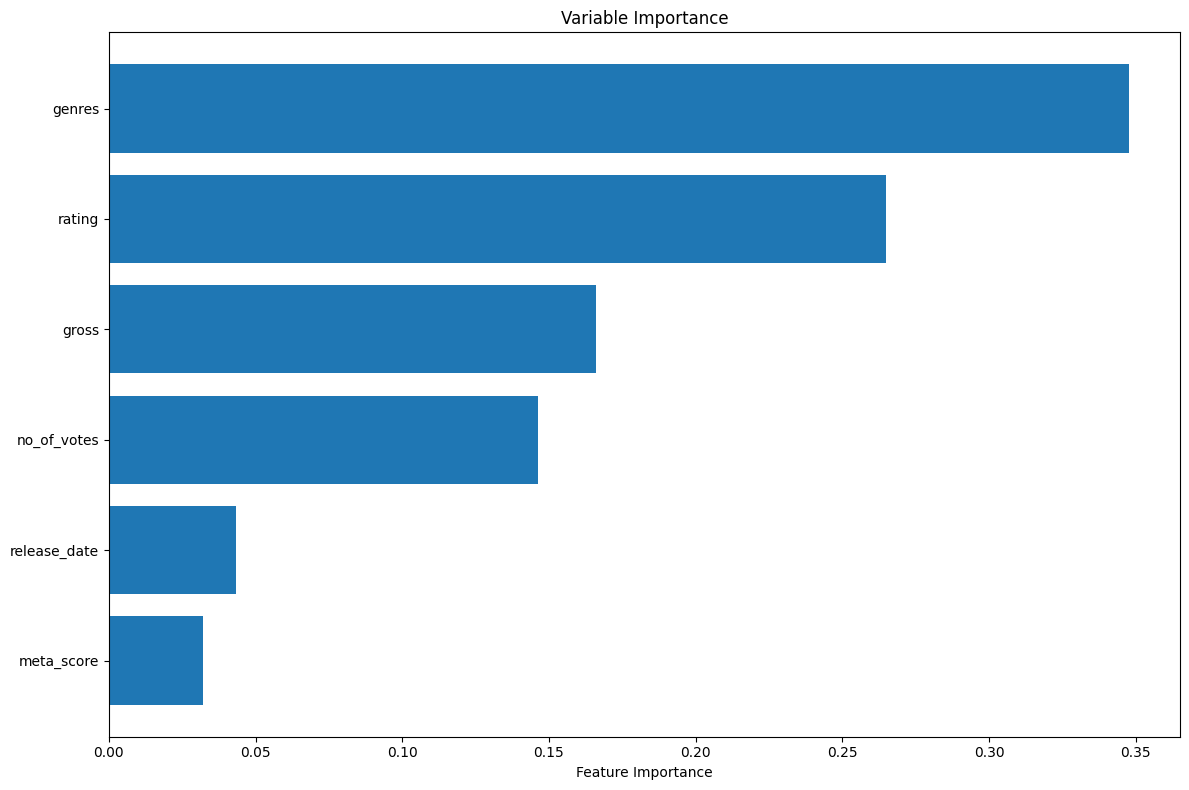


Fold 5
 Best hyperparameters: {'n_estimators': 384, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.6678312704250025
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8423
MAE: 35,440,662.2611
MAPE: 1.47%
Test Metrics
R2 score: 0.6086
MAE: 57,647,693.7211
MAPE: 4.94%


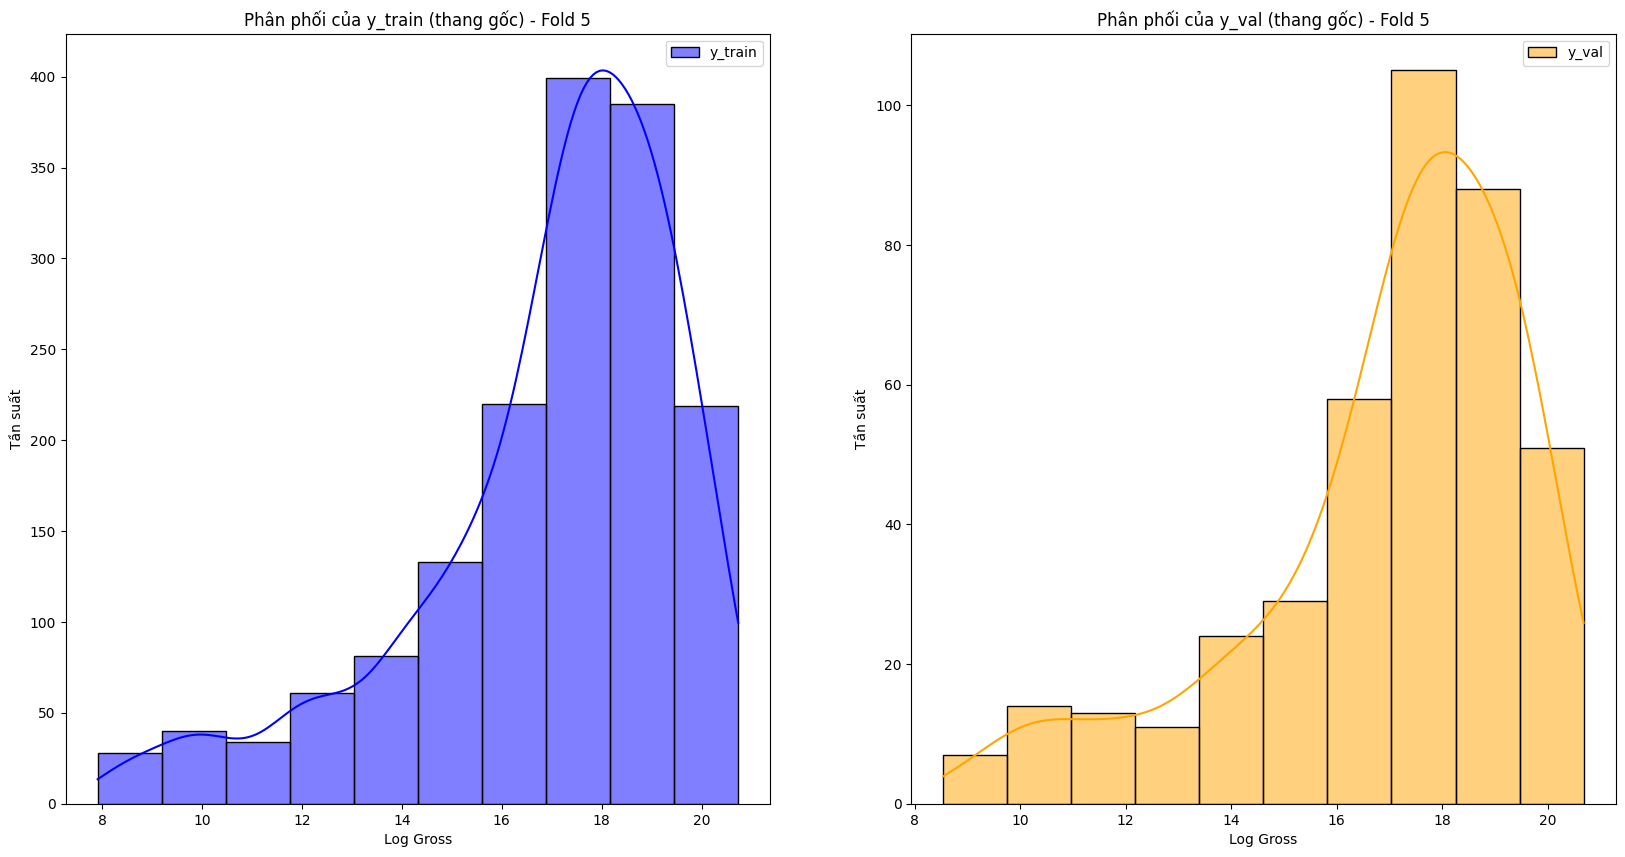

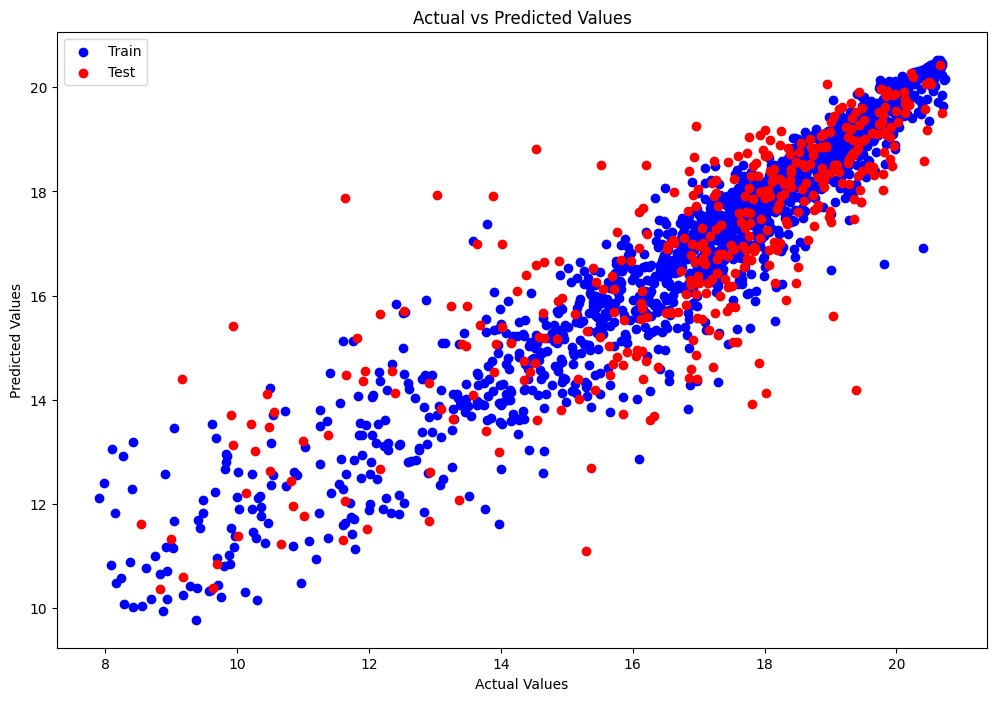

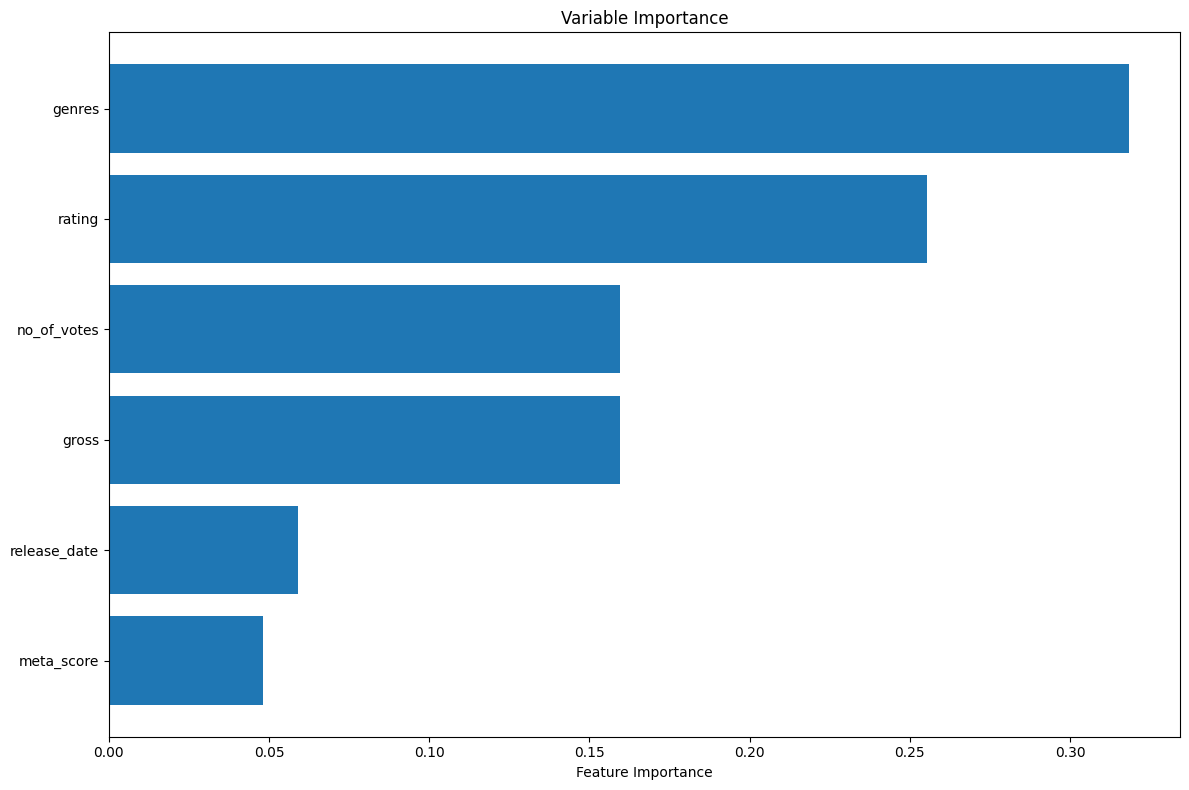

In [4]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from evaluation import visualize_results
import warnings

# warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\nFold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    # Chọn đặc trưng đầu vào và mục tiêu
    #features = ['meta_score', 'rating', 'no_of_votes', 'budget', 'genre_stat_feature', 'country_stat_feature', 'release_date']
    features = ['no_of_votes', 'log_budget',
                'genre_stat_feature','country_stat_feature','rating','release_date']

    target = 'log_gross'

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            'random_state': 42,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
        return -score  # minimize MSE

    #  Tạo study với tên rõ ràng theo từng fold
    study = optuna.create_study(direction="minimize", study_name=f"Fold_{fold+1}_RandomForest")
    study.optimize(objective, n_trials=30)

    print(" Best hyperparameters:", study.best_params)
    print(" Best MSE:", study.best_value)

    best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    #  Vẽ biểu đồ tối ưu và tầm quan trọng tham số
    print(" Hiển thị quá trình tối ưu:")
    plot_optimization_history(study).show()
    plot_param_importances(study).show()

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )
